<h1 style="color:blue; text-align:center">Week 9: Data Cleansing and Transformation</h1>

<hr>

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import os

In [76]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/bank-additional-full.csv", sep=";")

I've added some thoughts about NAs, ouliers and variable significance for each variable

1 - age (numeric) : No NAs.

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown') - unknown will be considered NA. We will use the mode to replace them, since the proportion of unknown is considerably small.

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed): the same method as at the job column is applied.

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown'): knn to replace the unknown, since it is an ordinal variable.

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

Those three I would either ignore the variable if we can prove that it's not significant enough or keep it as if unknown were another category. Default has more unknown than yes so is probable that it will be discarded. Housing has a similar frequency in both so we can compare between the frequencies they have of each y category. Loan has a few more yes than unknown but the solution of using the mode can be considered.


Related with the last contact of the current campaign:

8 - contact: contact communication type (categorical: 'cellular','telephone'): no NAs

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec'): no NAs

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri'): no NAs

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model: no NAs


Other attributes:

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact): no NAs

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted): I would include a binary column with if the client has been contacted before. Not sure how to handle the 999 since the different scale can't be keep that extreme

14 - previous: number of contacts performed before this campaign and for this client (numeric): no NA

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success'): considering the frequency table, it will be ignore or considered nonexistent like another value.


Social and economic context attributes

16 - emp.var.rate: employment variation rate - quarterly indicator (numeric) :  no NAs

17 - cons.price.idx: consumer price index - monthly indicator (numeric) : no NAs. judging the std it has, it highly likely that it won't give much information

18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric) :  no NAs

19 - euribor3m: euribor 3 month rate - daily indicator (numeric): no NAs

20 - nr.employed: number of employees - quarterly indicator (numeric): no NAs


Output variable (desired target):

21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [77]:
data.shape

(41188, 21)

In [78]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


---------------------------------------------------------------------------------
age:


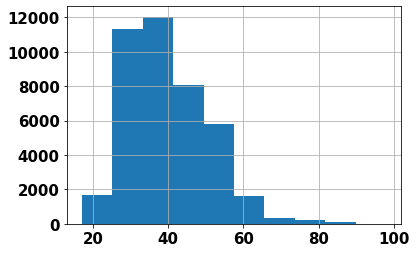

---------------------------------------------------------------------------------
duration:


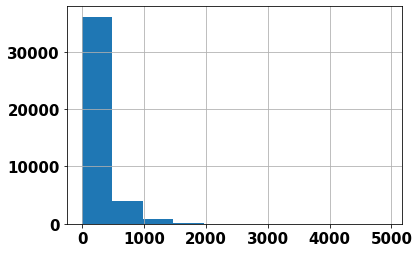

---------------------------------------------------------------------------------
campaign:


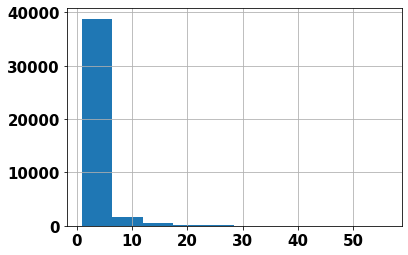

---------------------------------------------------------------------------------
pdays:


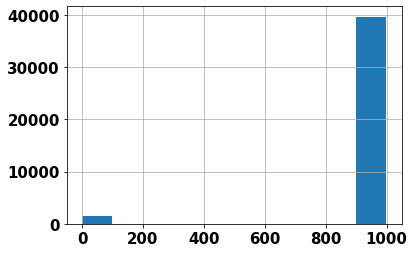

---------------------------------------------------------------------------------
previous:


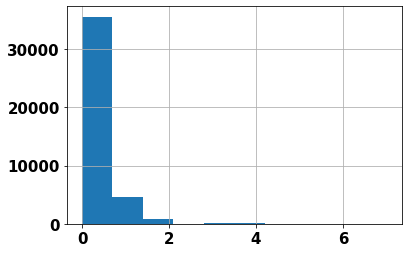

---------------------------------------------------------------------------------
emp.var.rate:


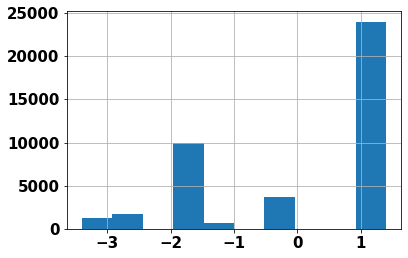

---------------------------------------------------------------------------------
cons.price.idx:


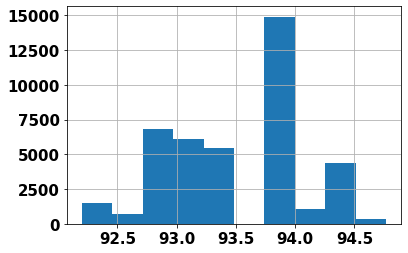

---------------------------------------------------------------------------------
cons.conf.idx:


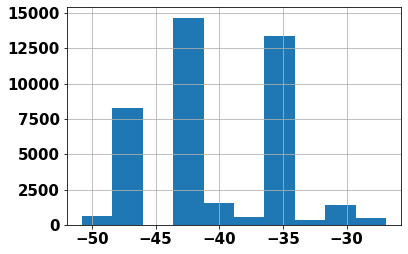

---------------------------------------------------------------------------------
euribor3m:


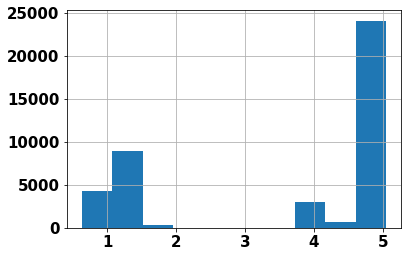

---------------------------------------------------------------------------------
nr.employed:


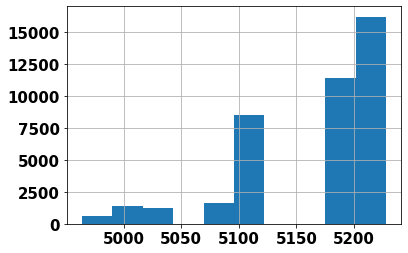

In [79]:
for col in data.describe().columns:
    print("---------------------------------------------------------------------------------")
    print(col + ':')
    data.loc[:, col].hist()
    plt.show()

In [80]:
data.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


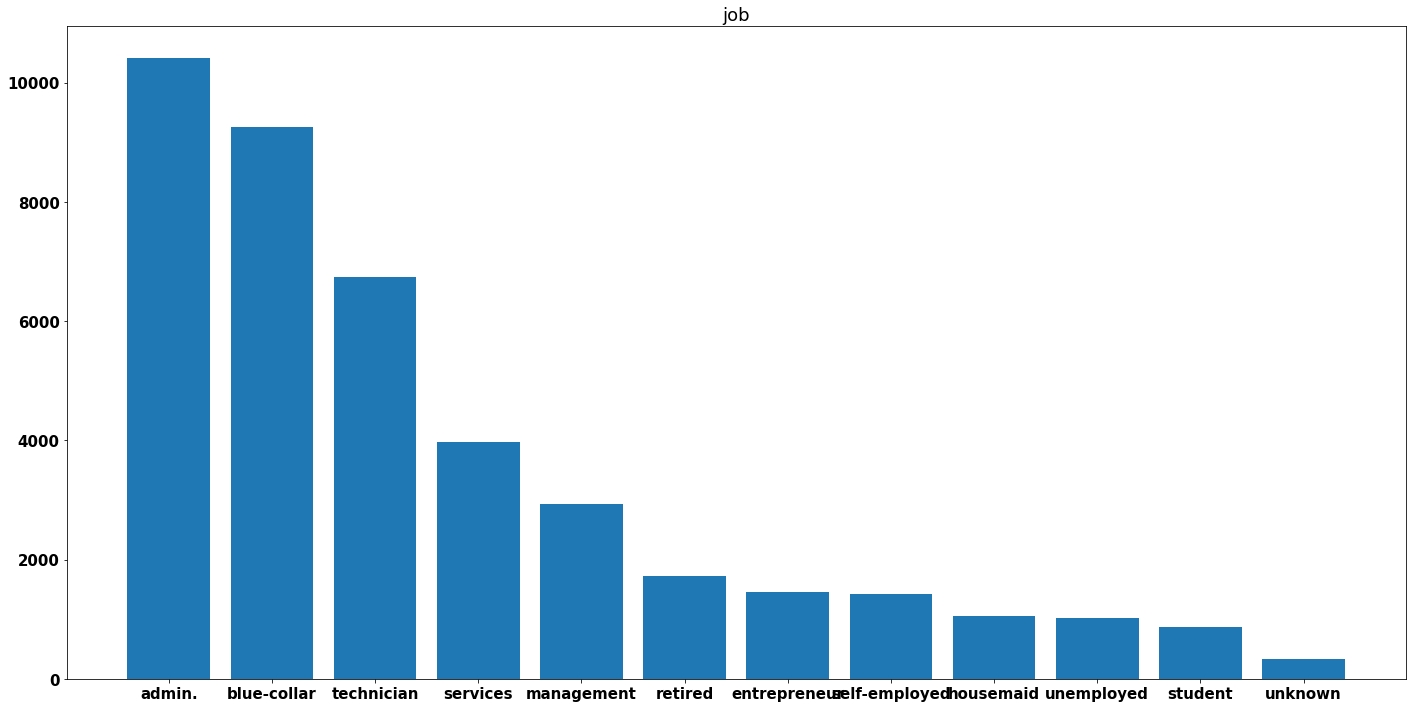

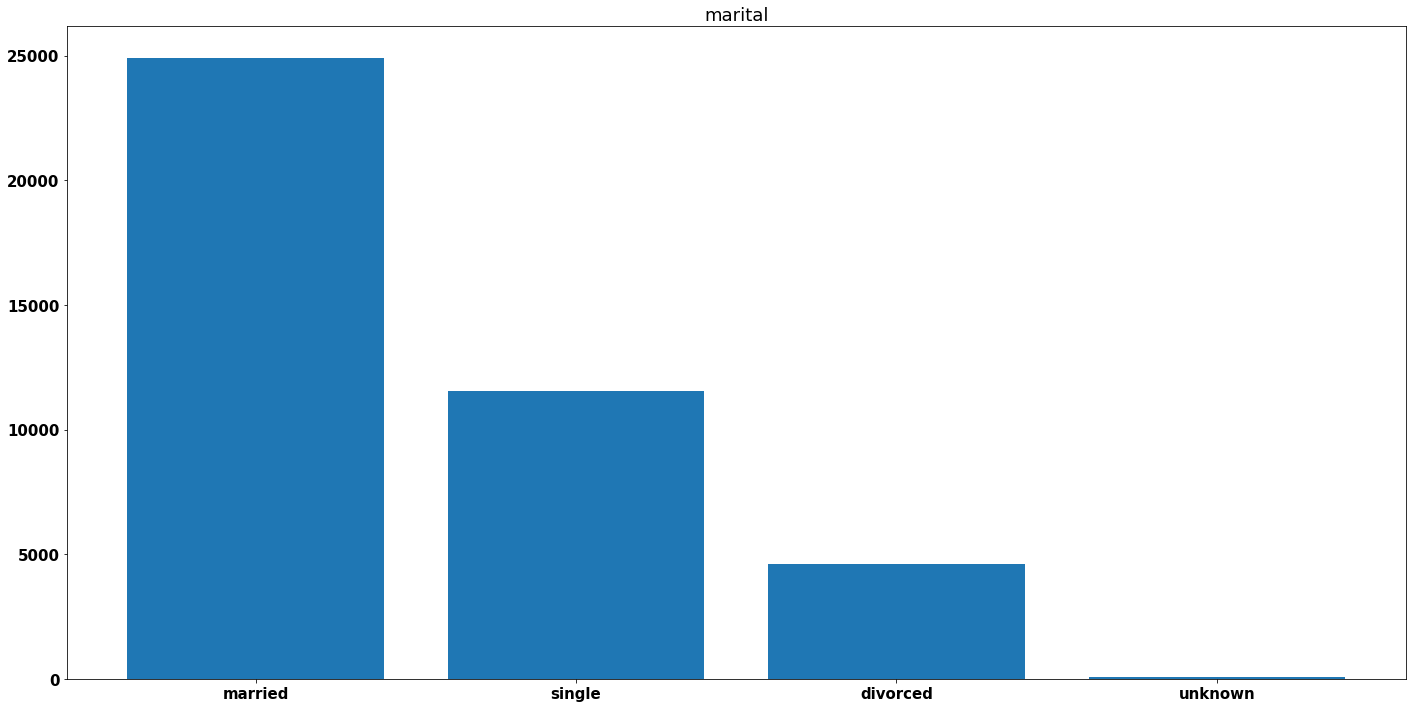

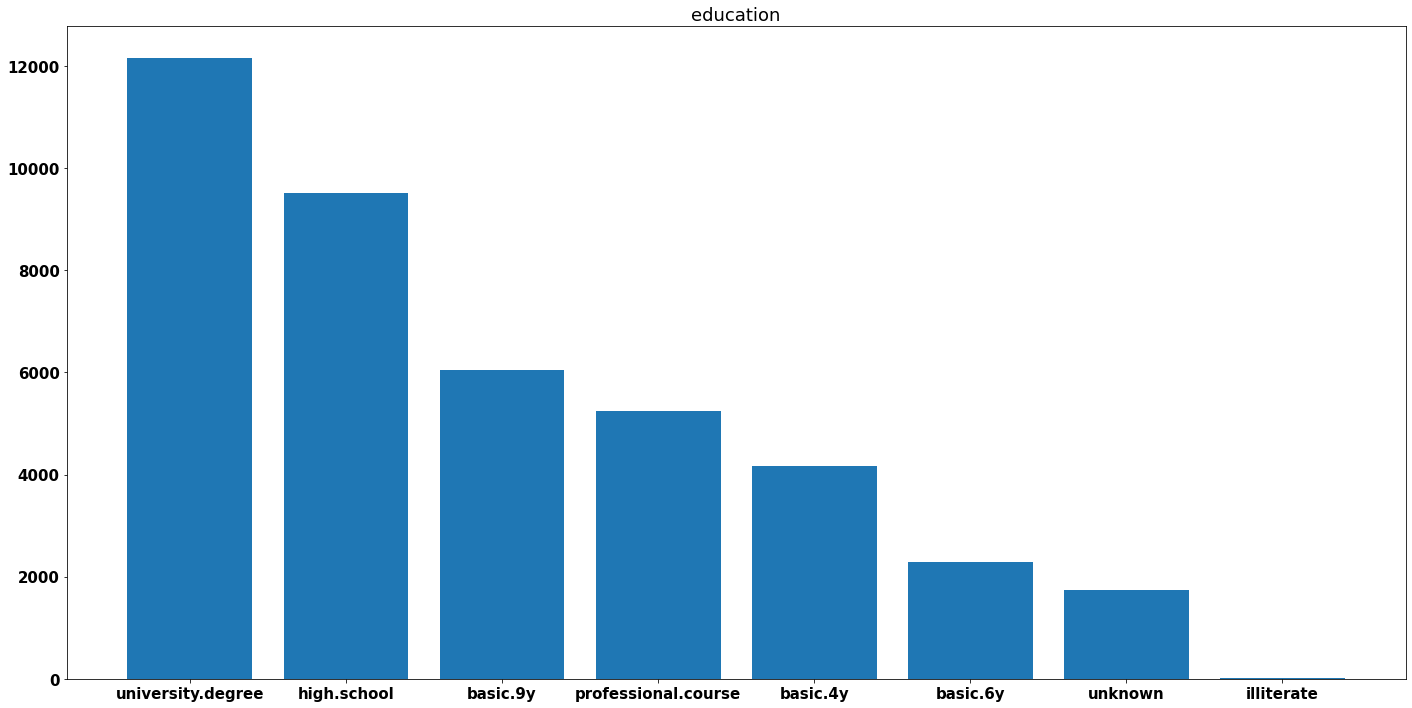

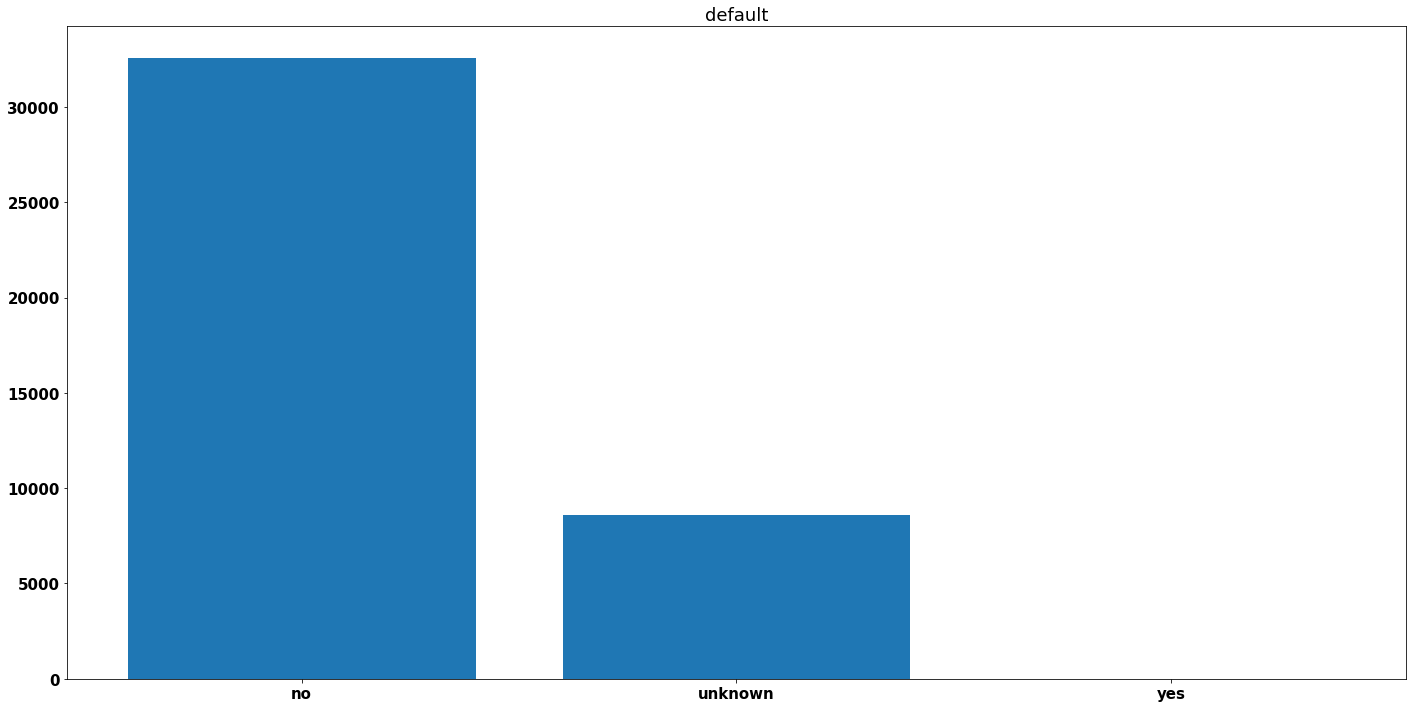

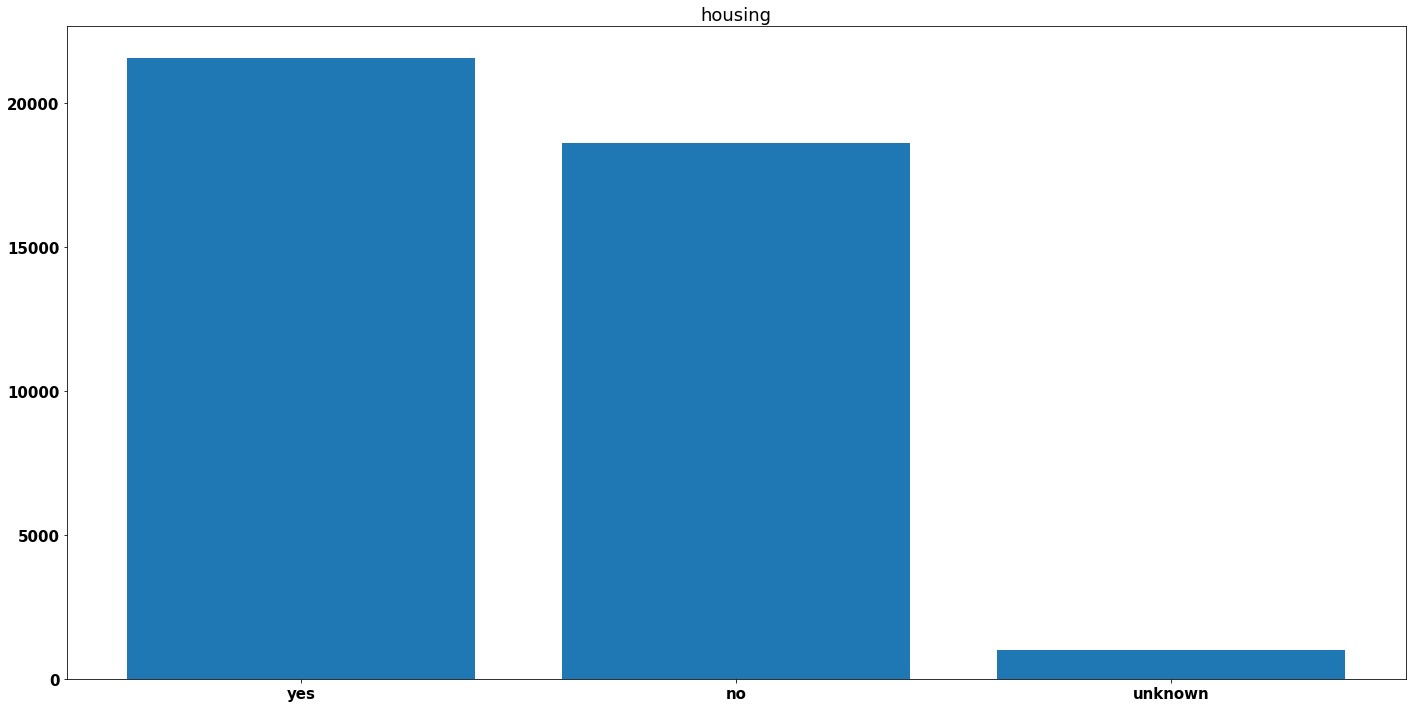

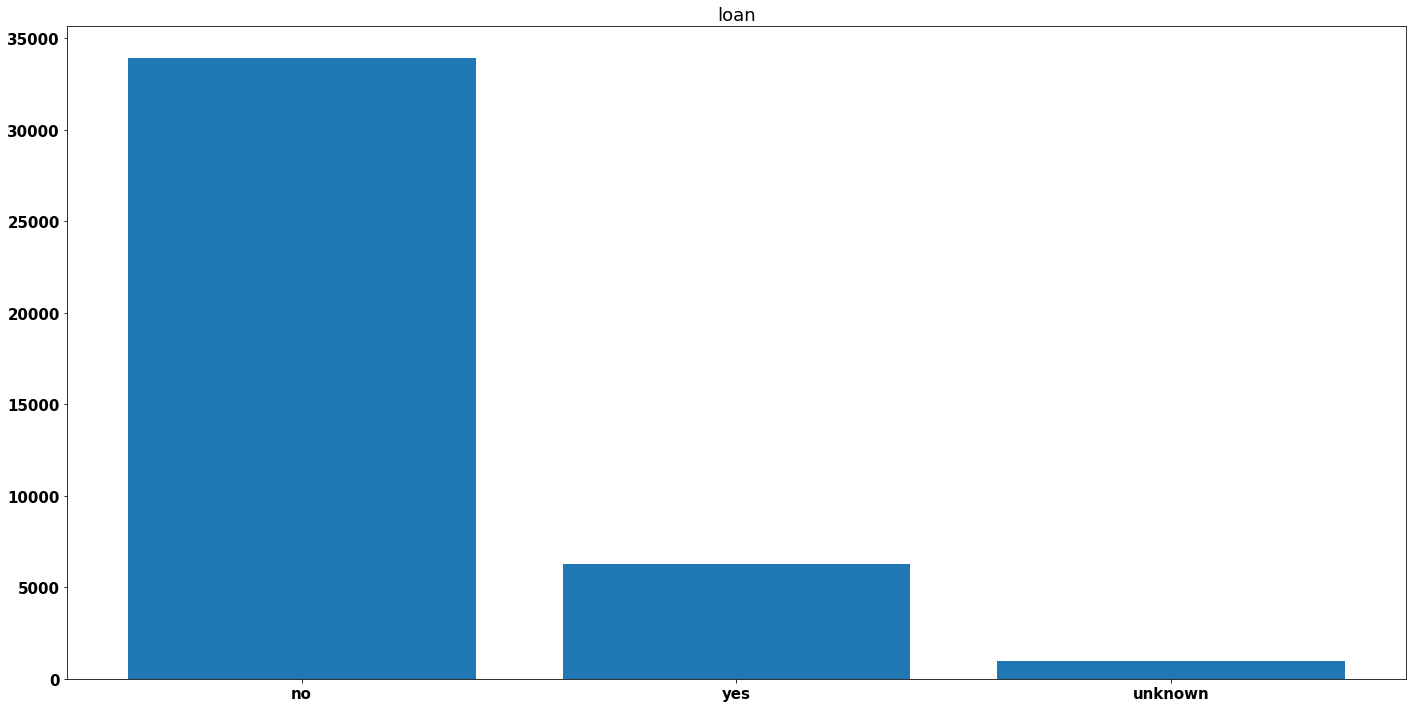

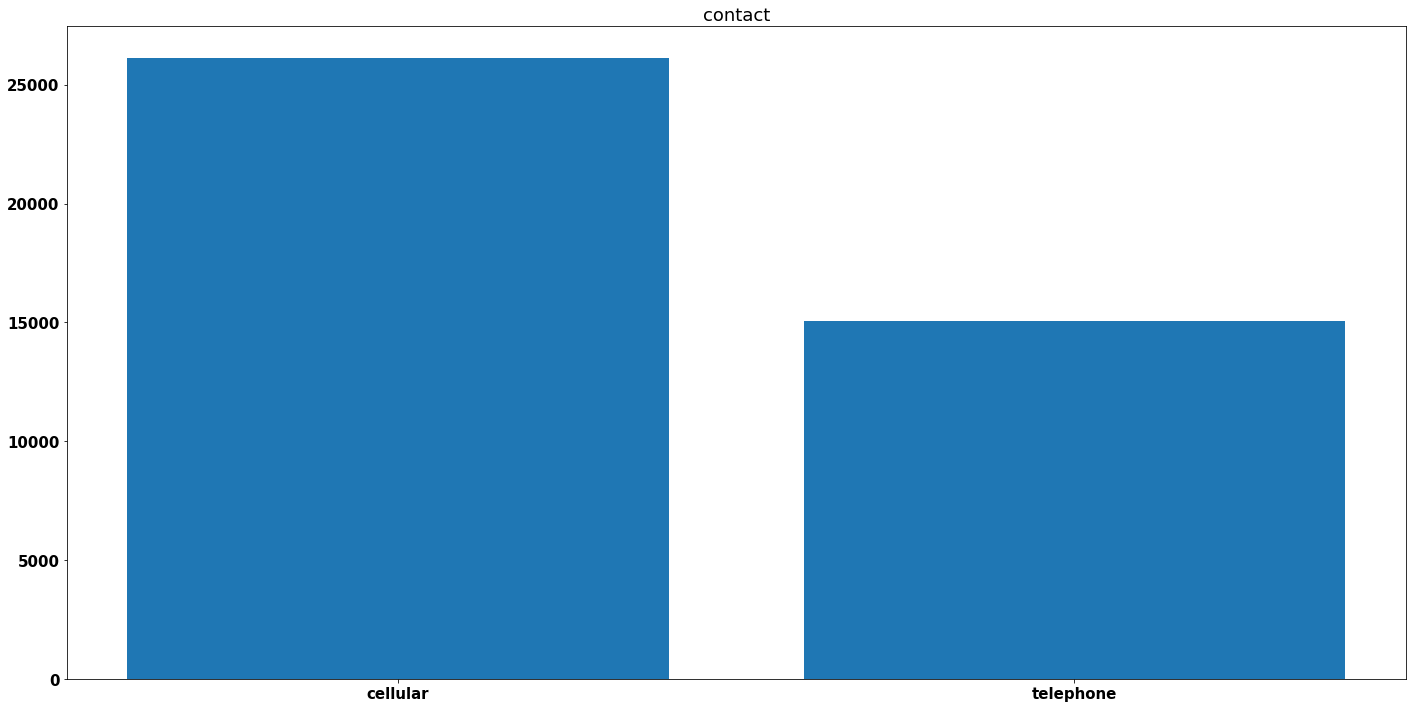

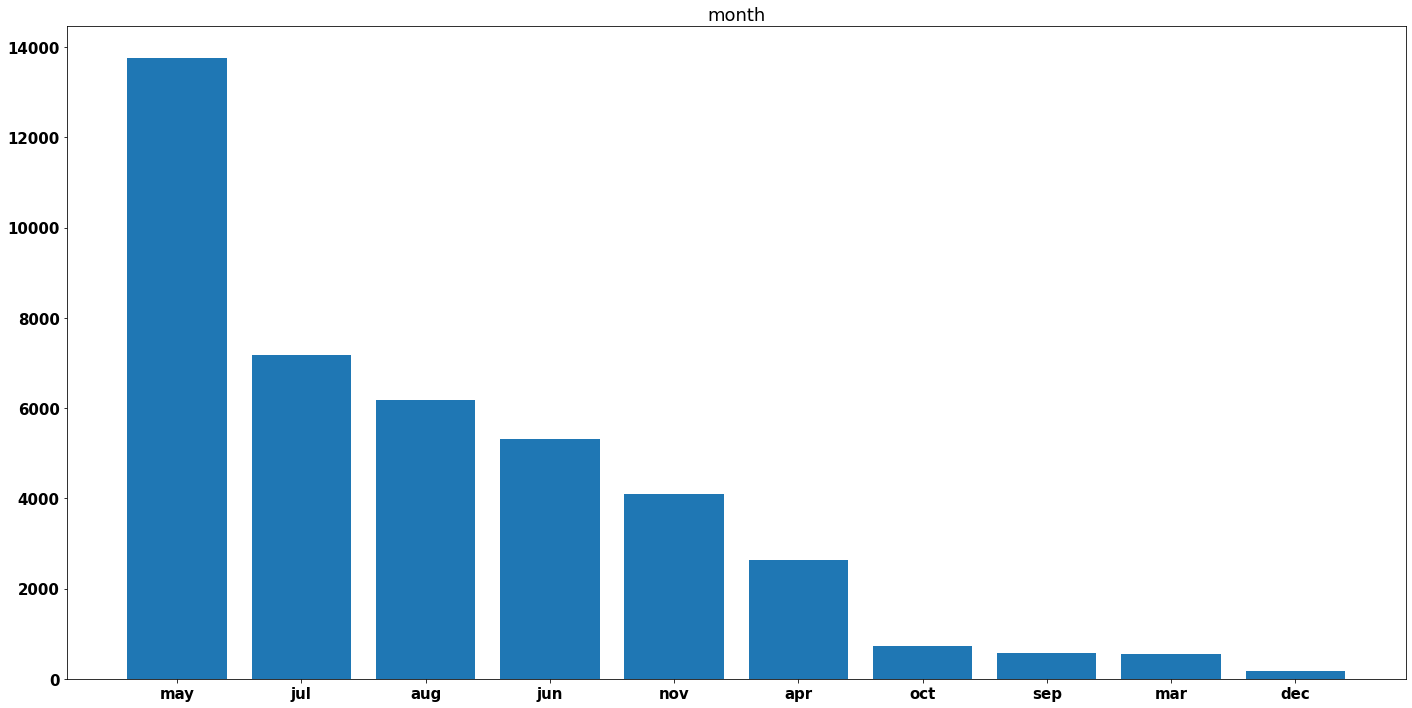

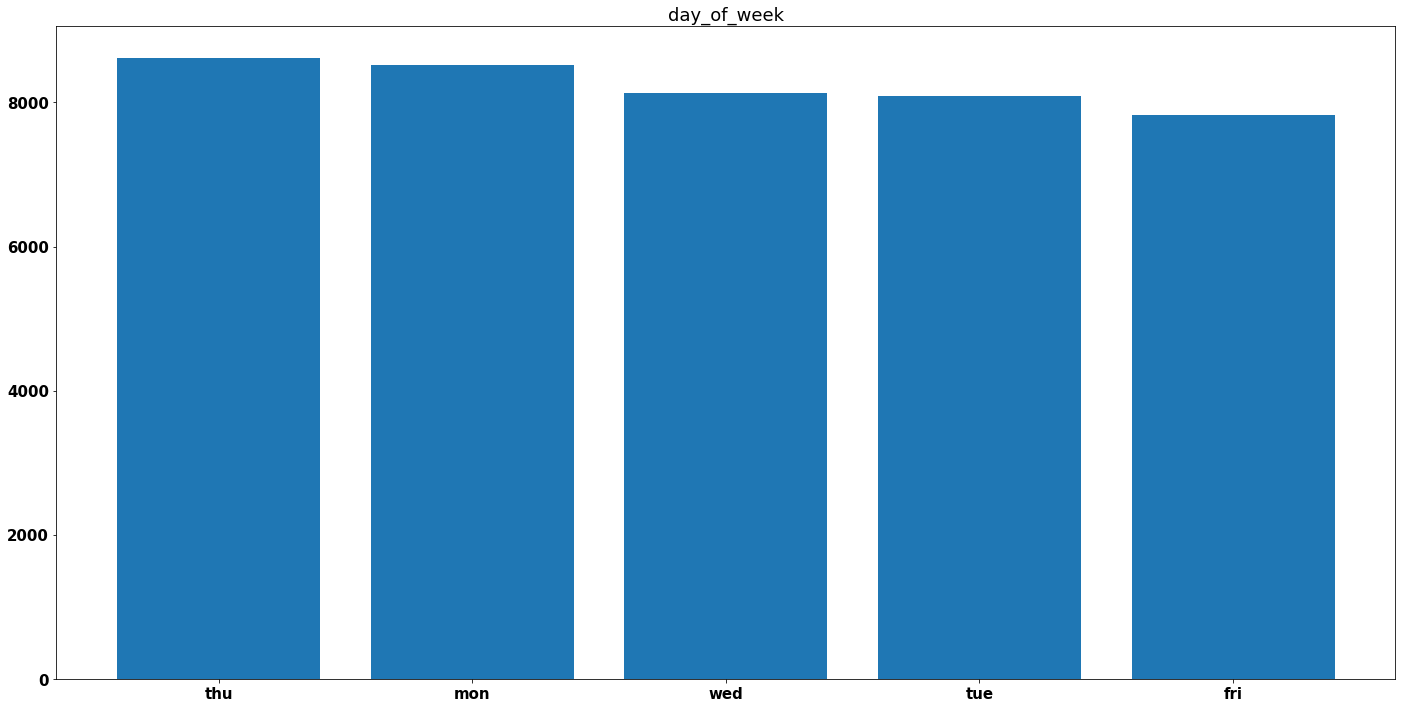

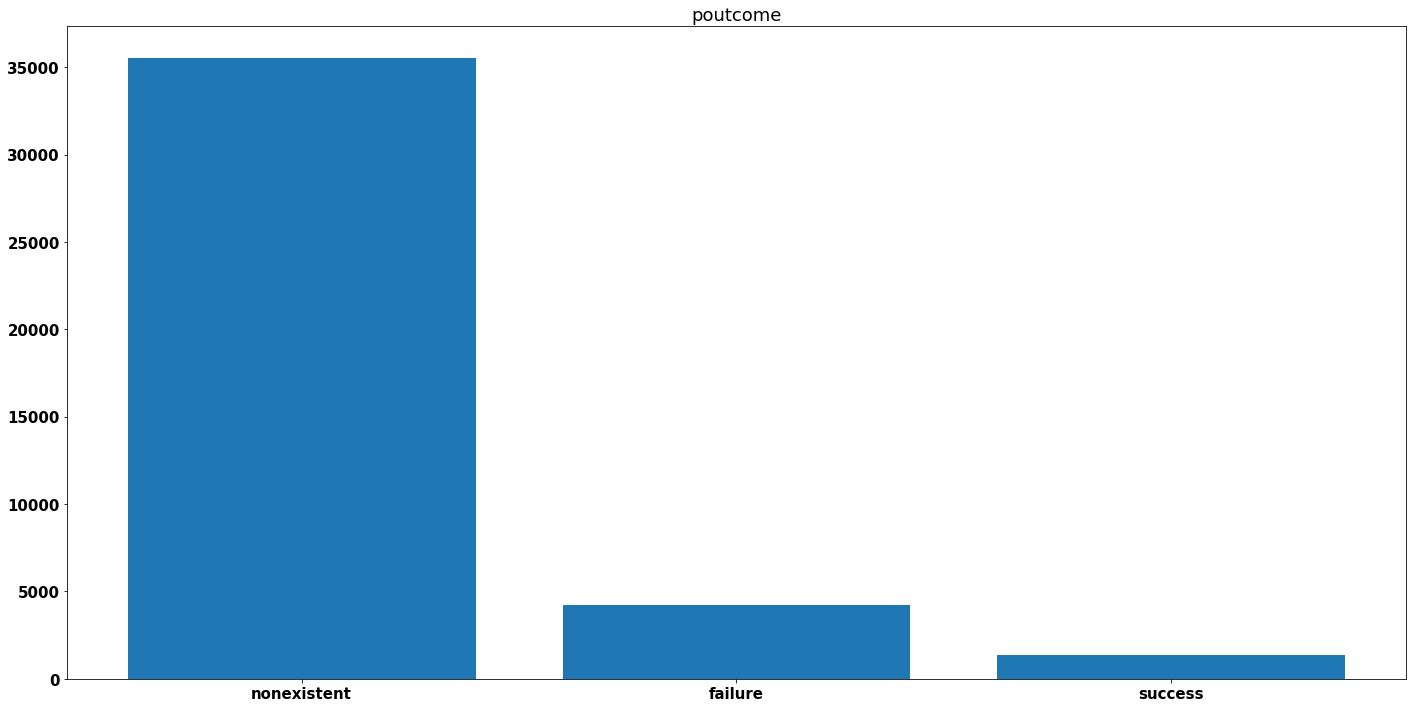

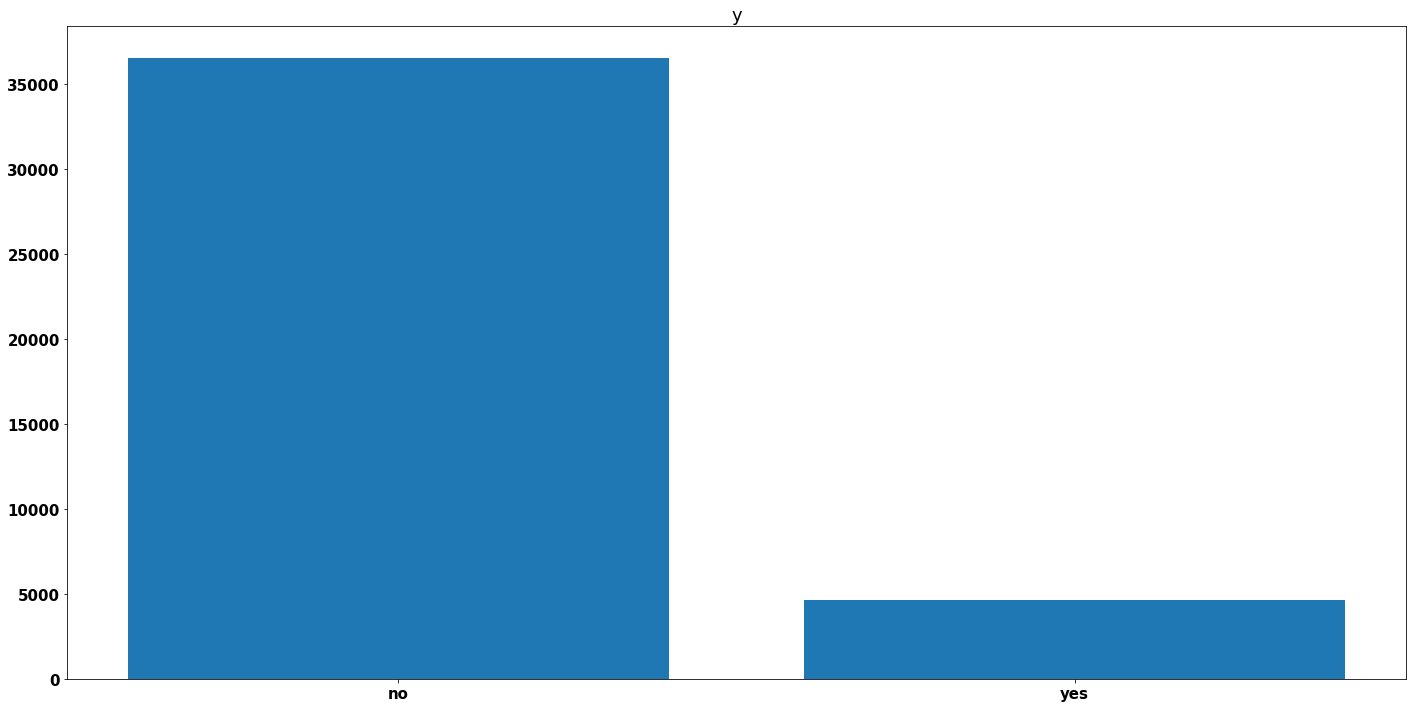

In [81]:
for col in data.describe(include='object').columns:
    fig, ax = plt.subplots(figsize=(24, 12))
    
    ax.bar(data.loc[:, col].value_counts().index, data.loc[:, col].value_counts().values)
    ax.set_title(col)

    plt.show()

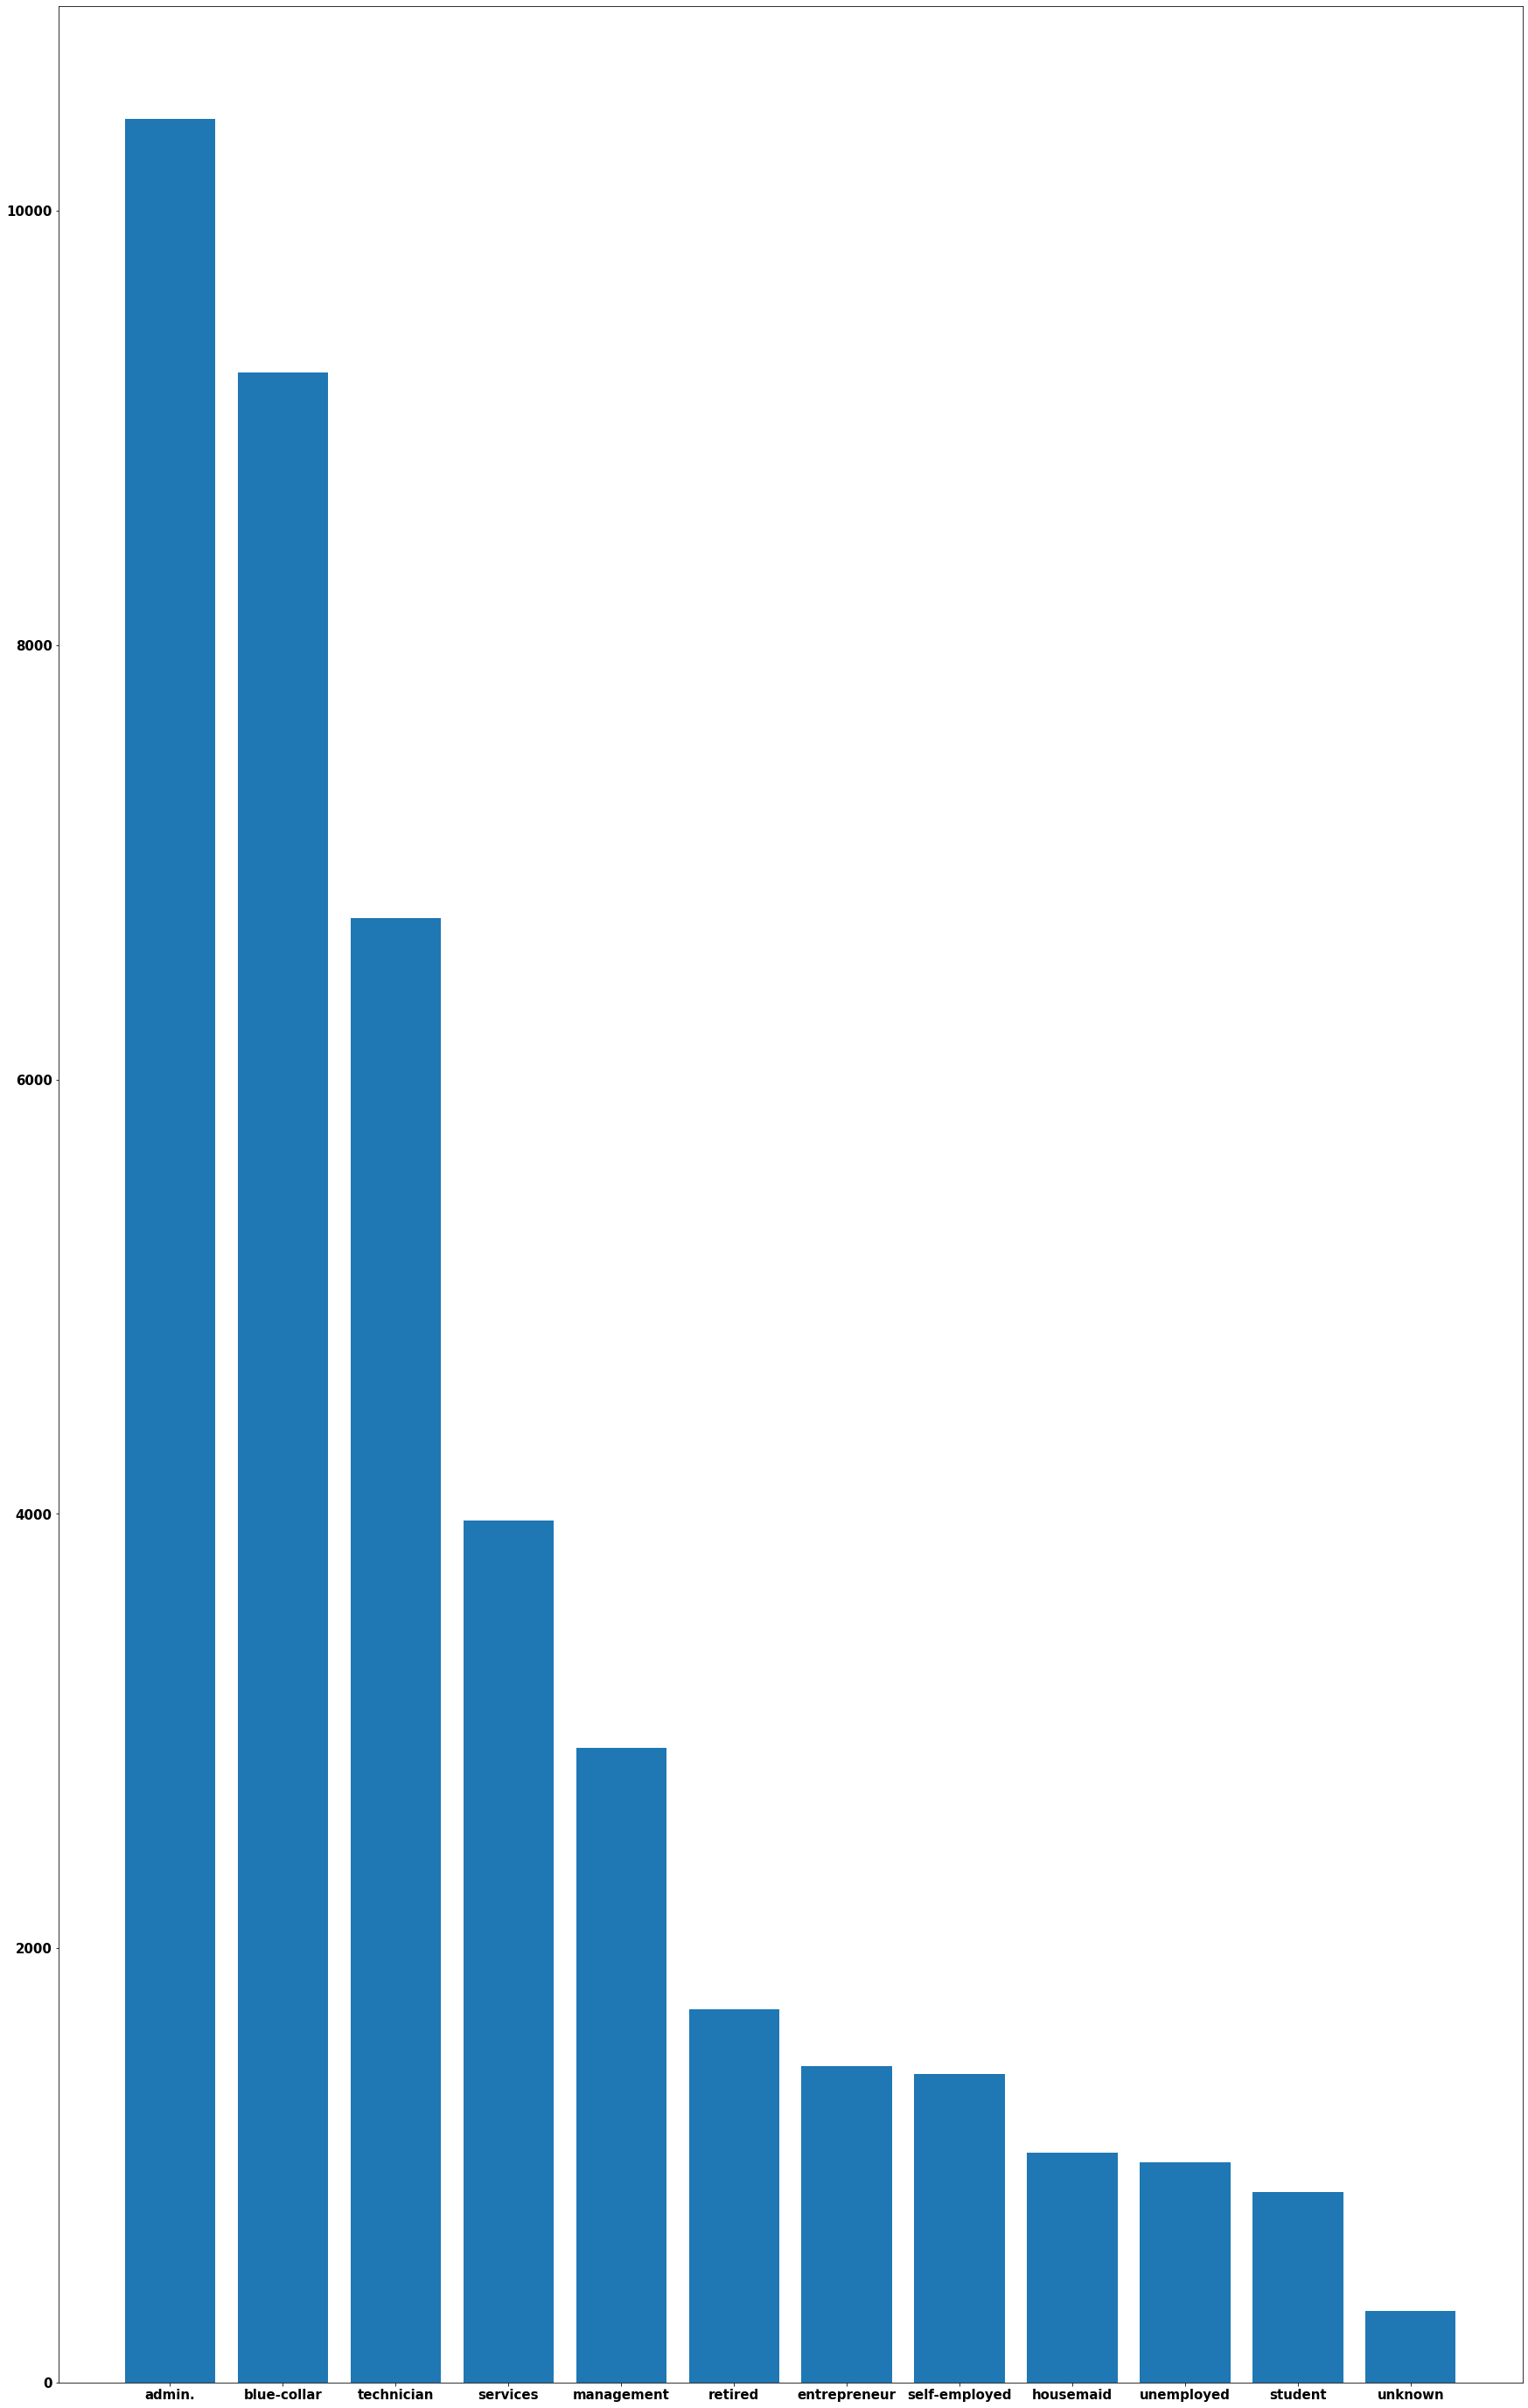

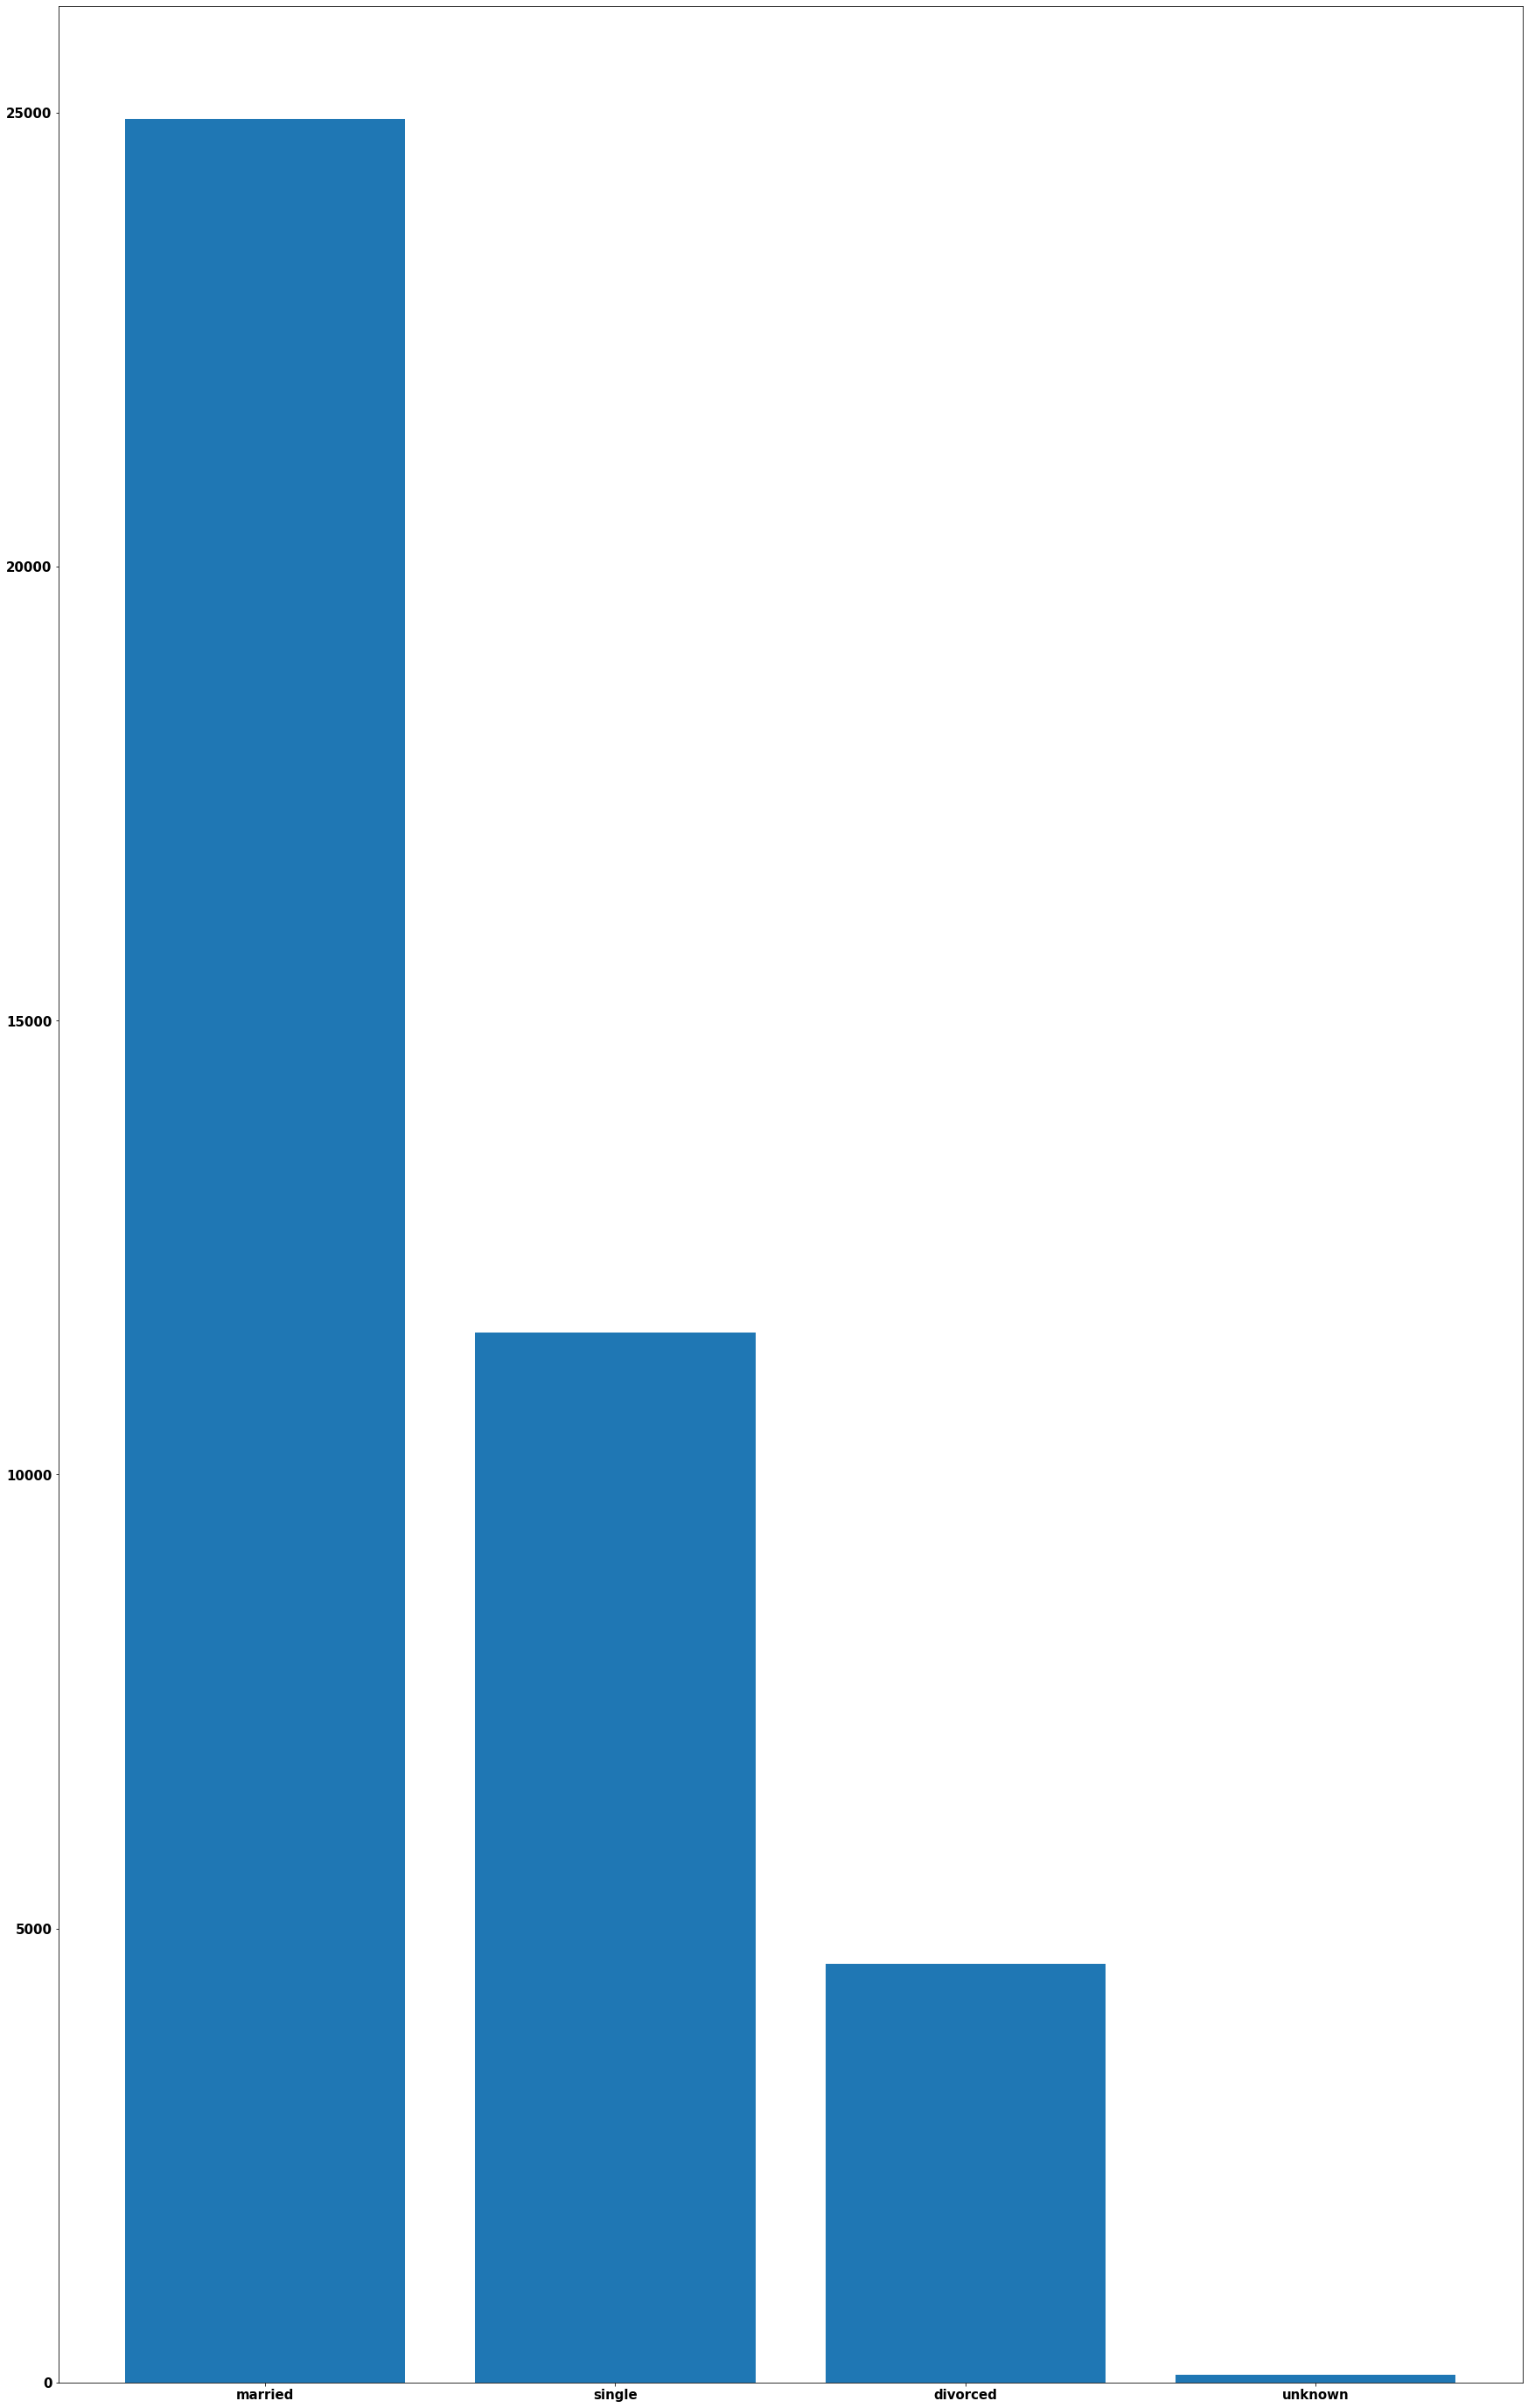

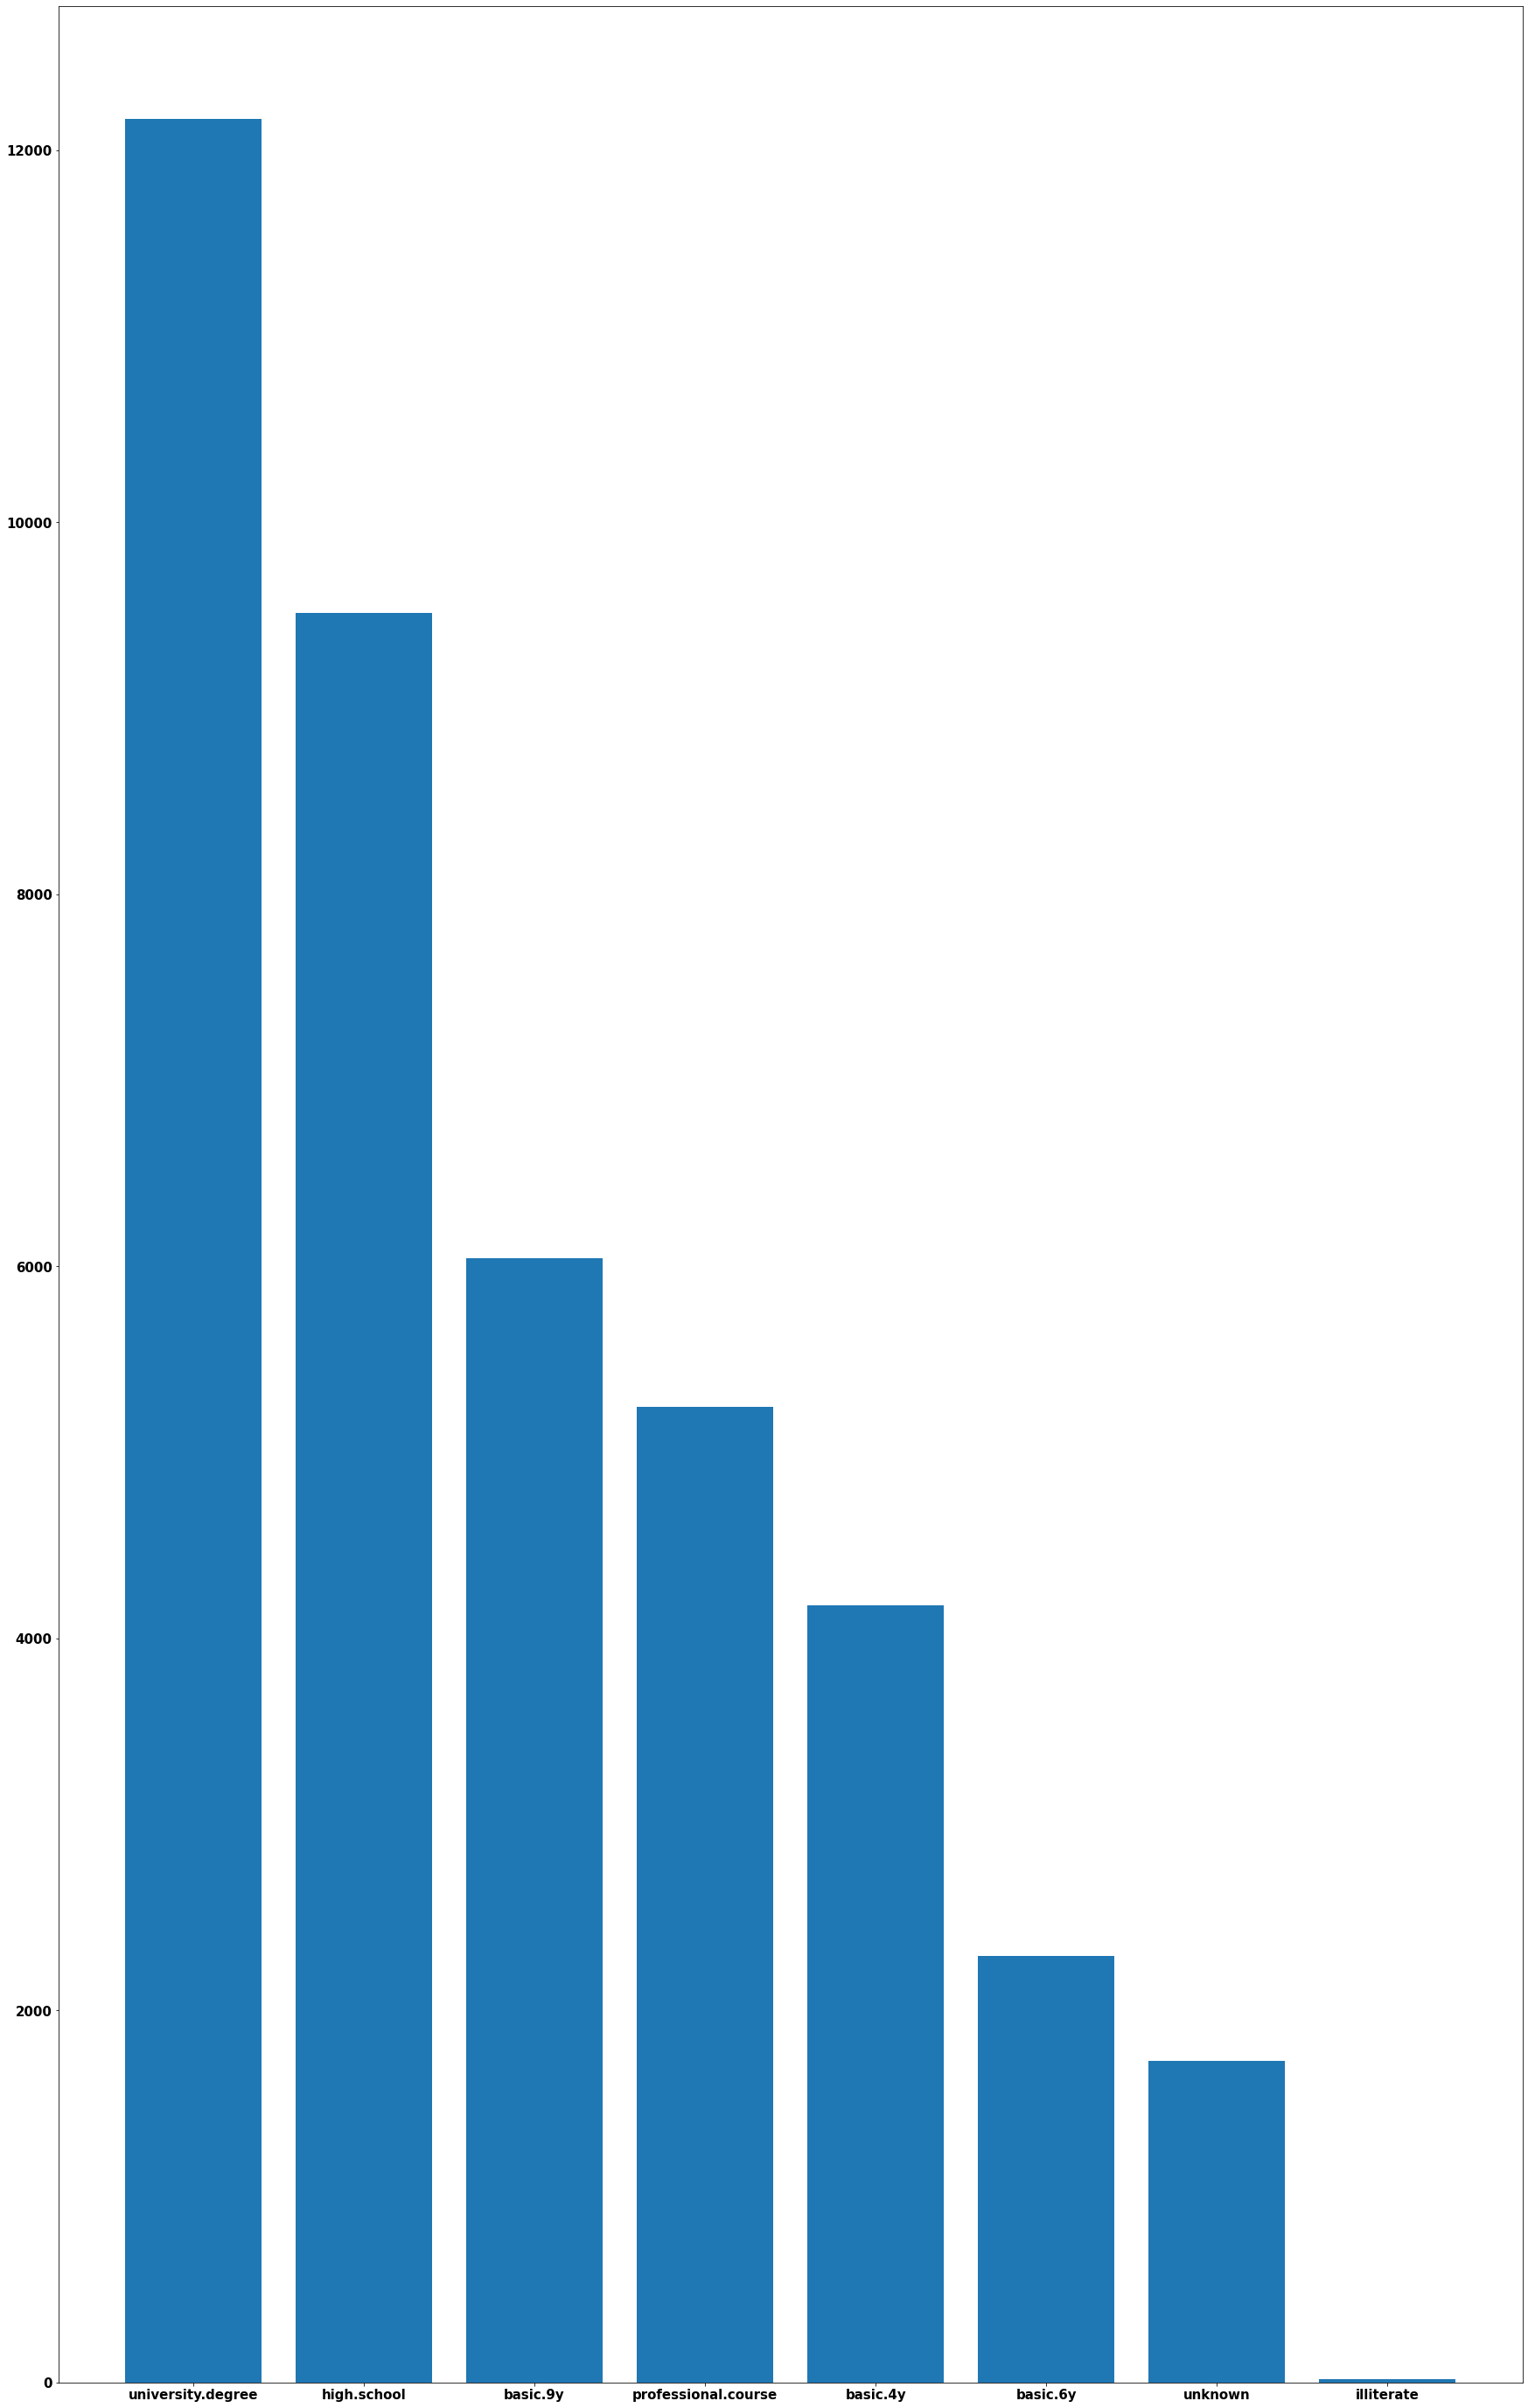

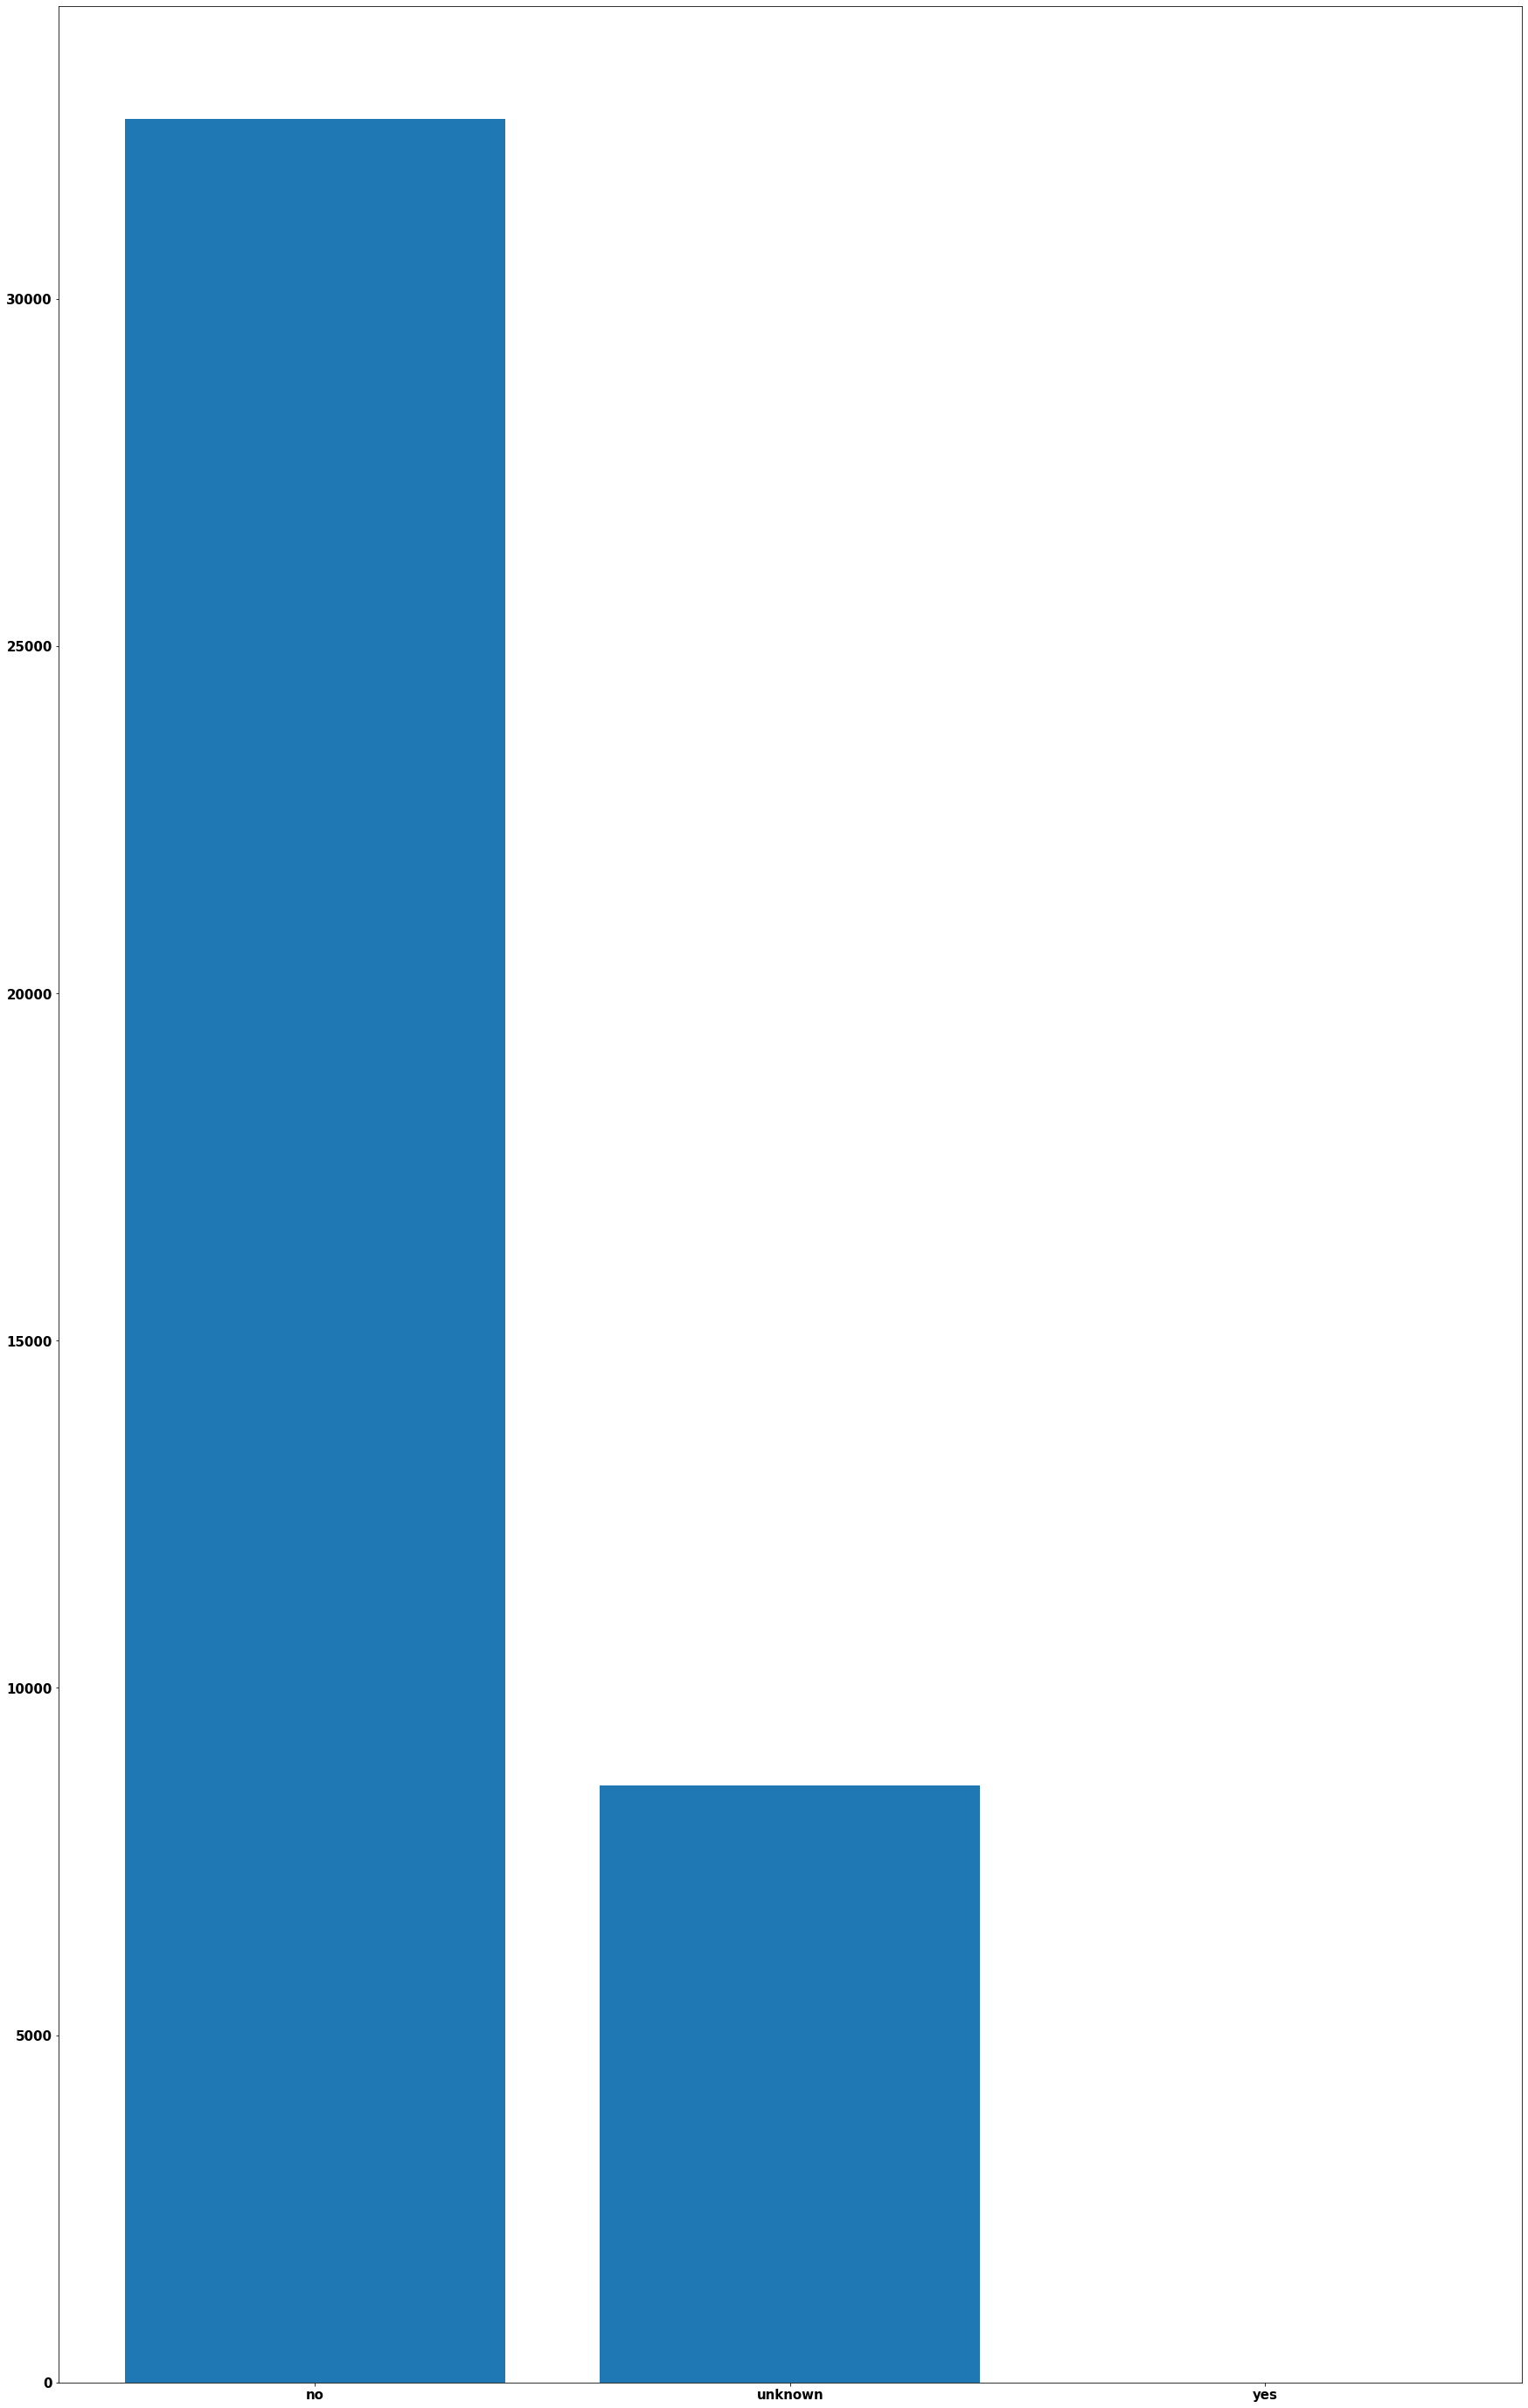

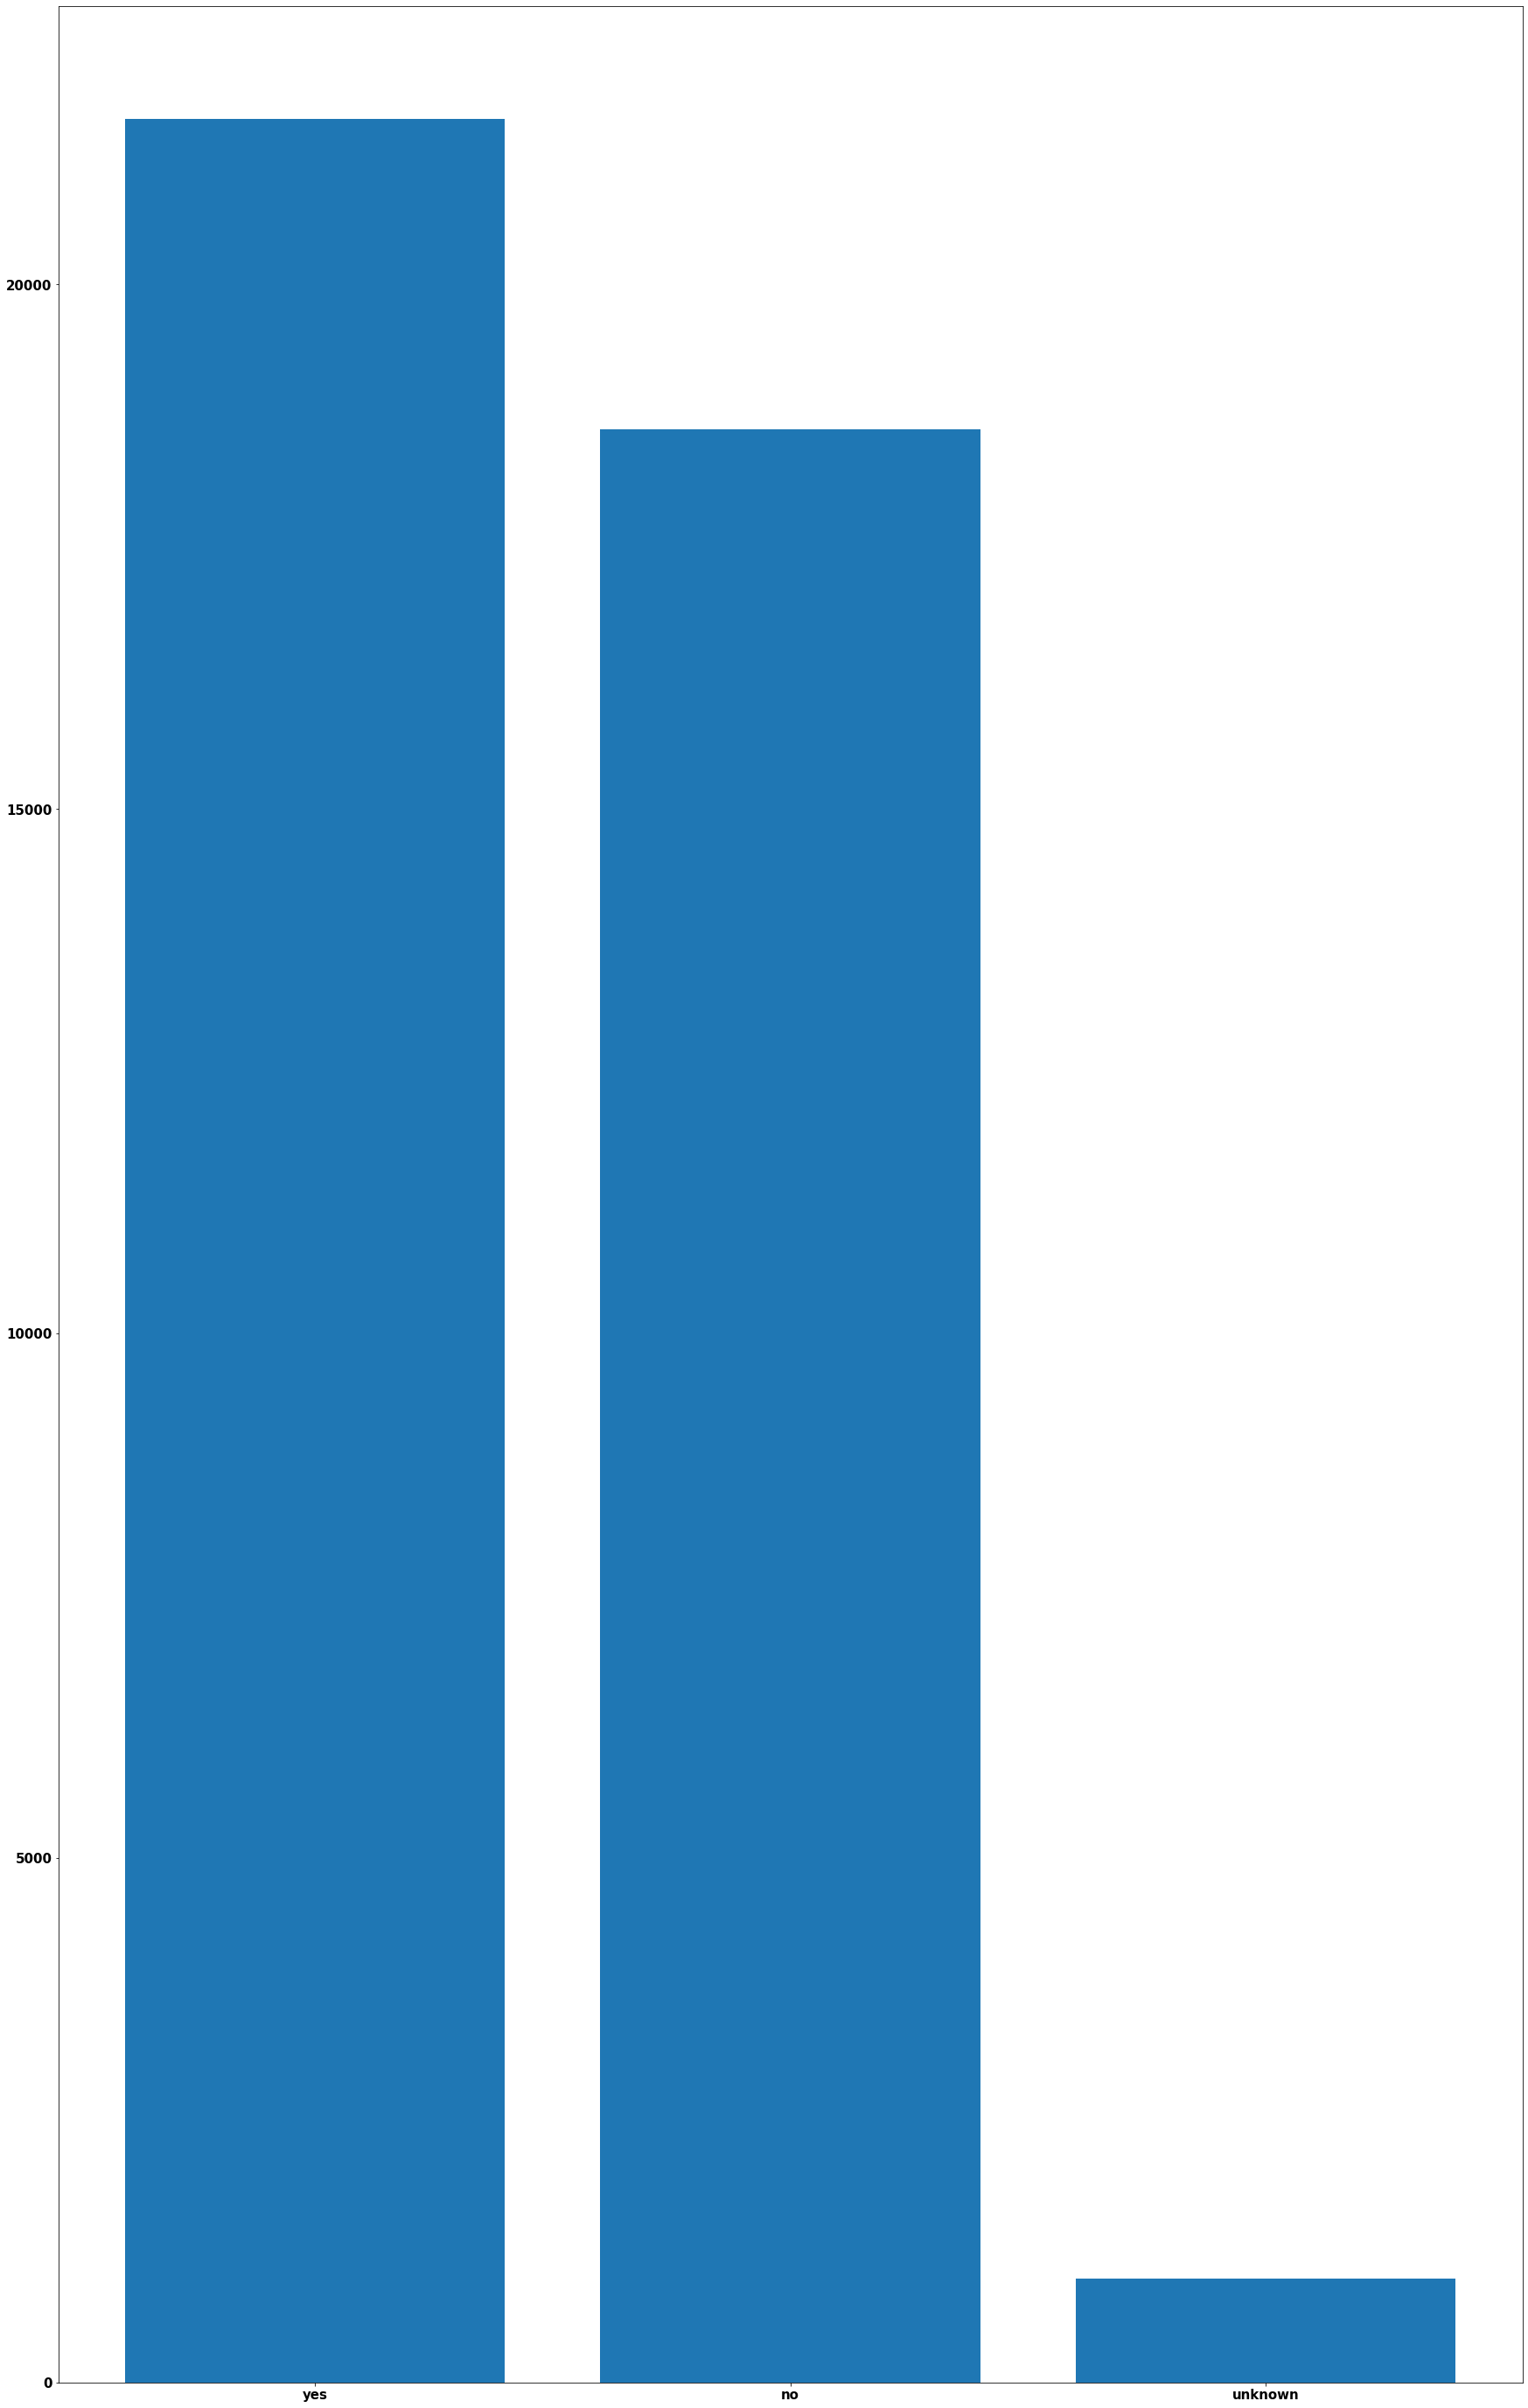

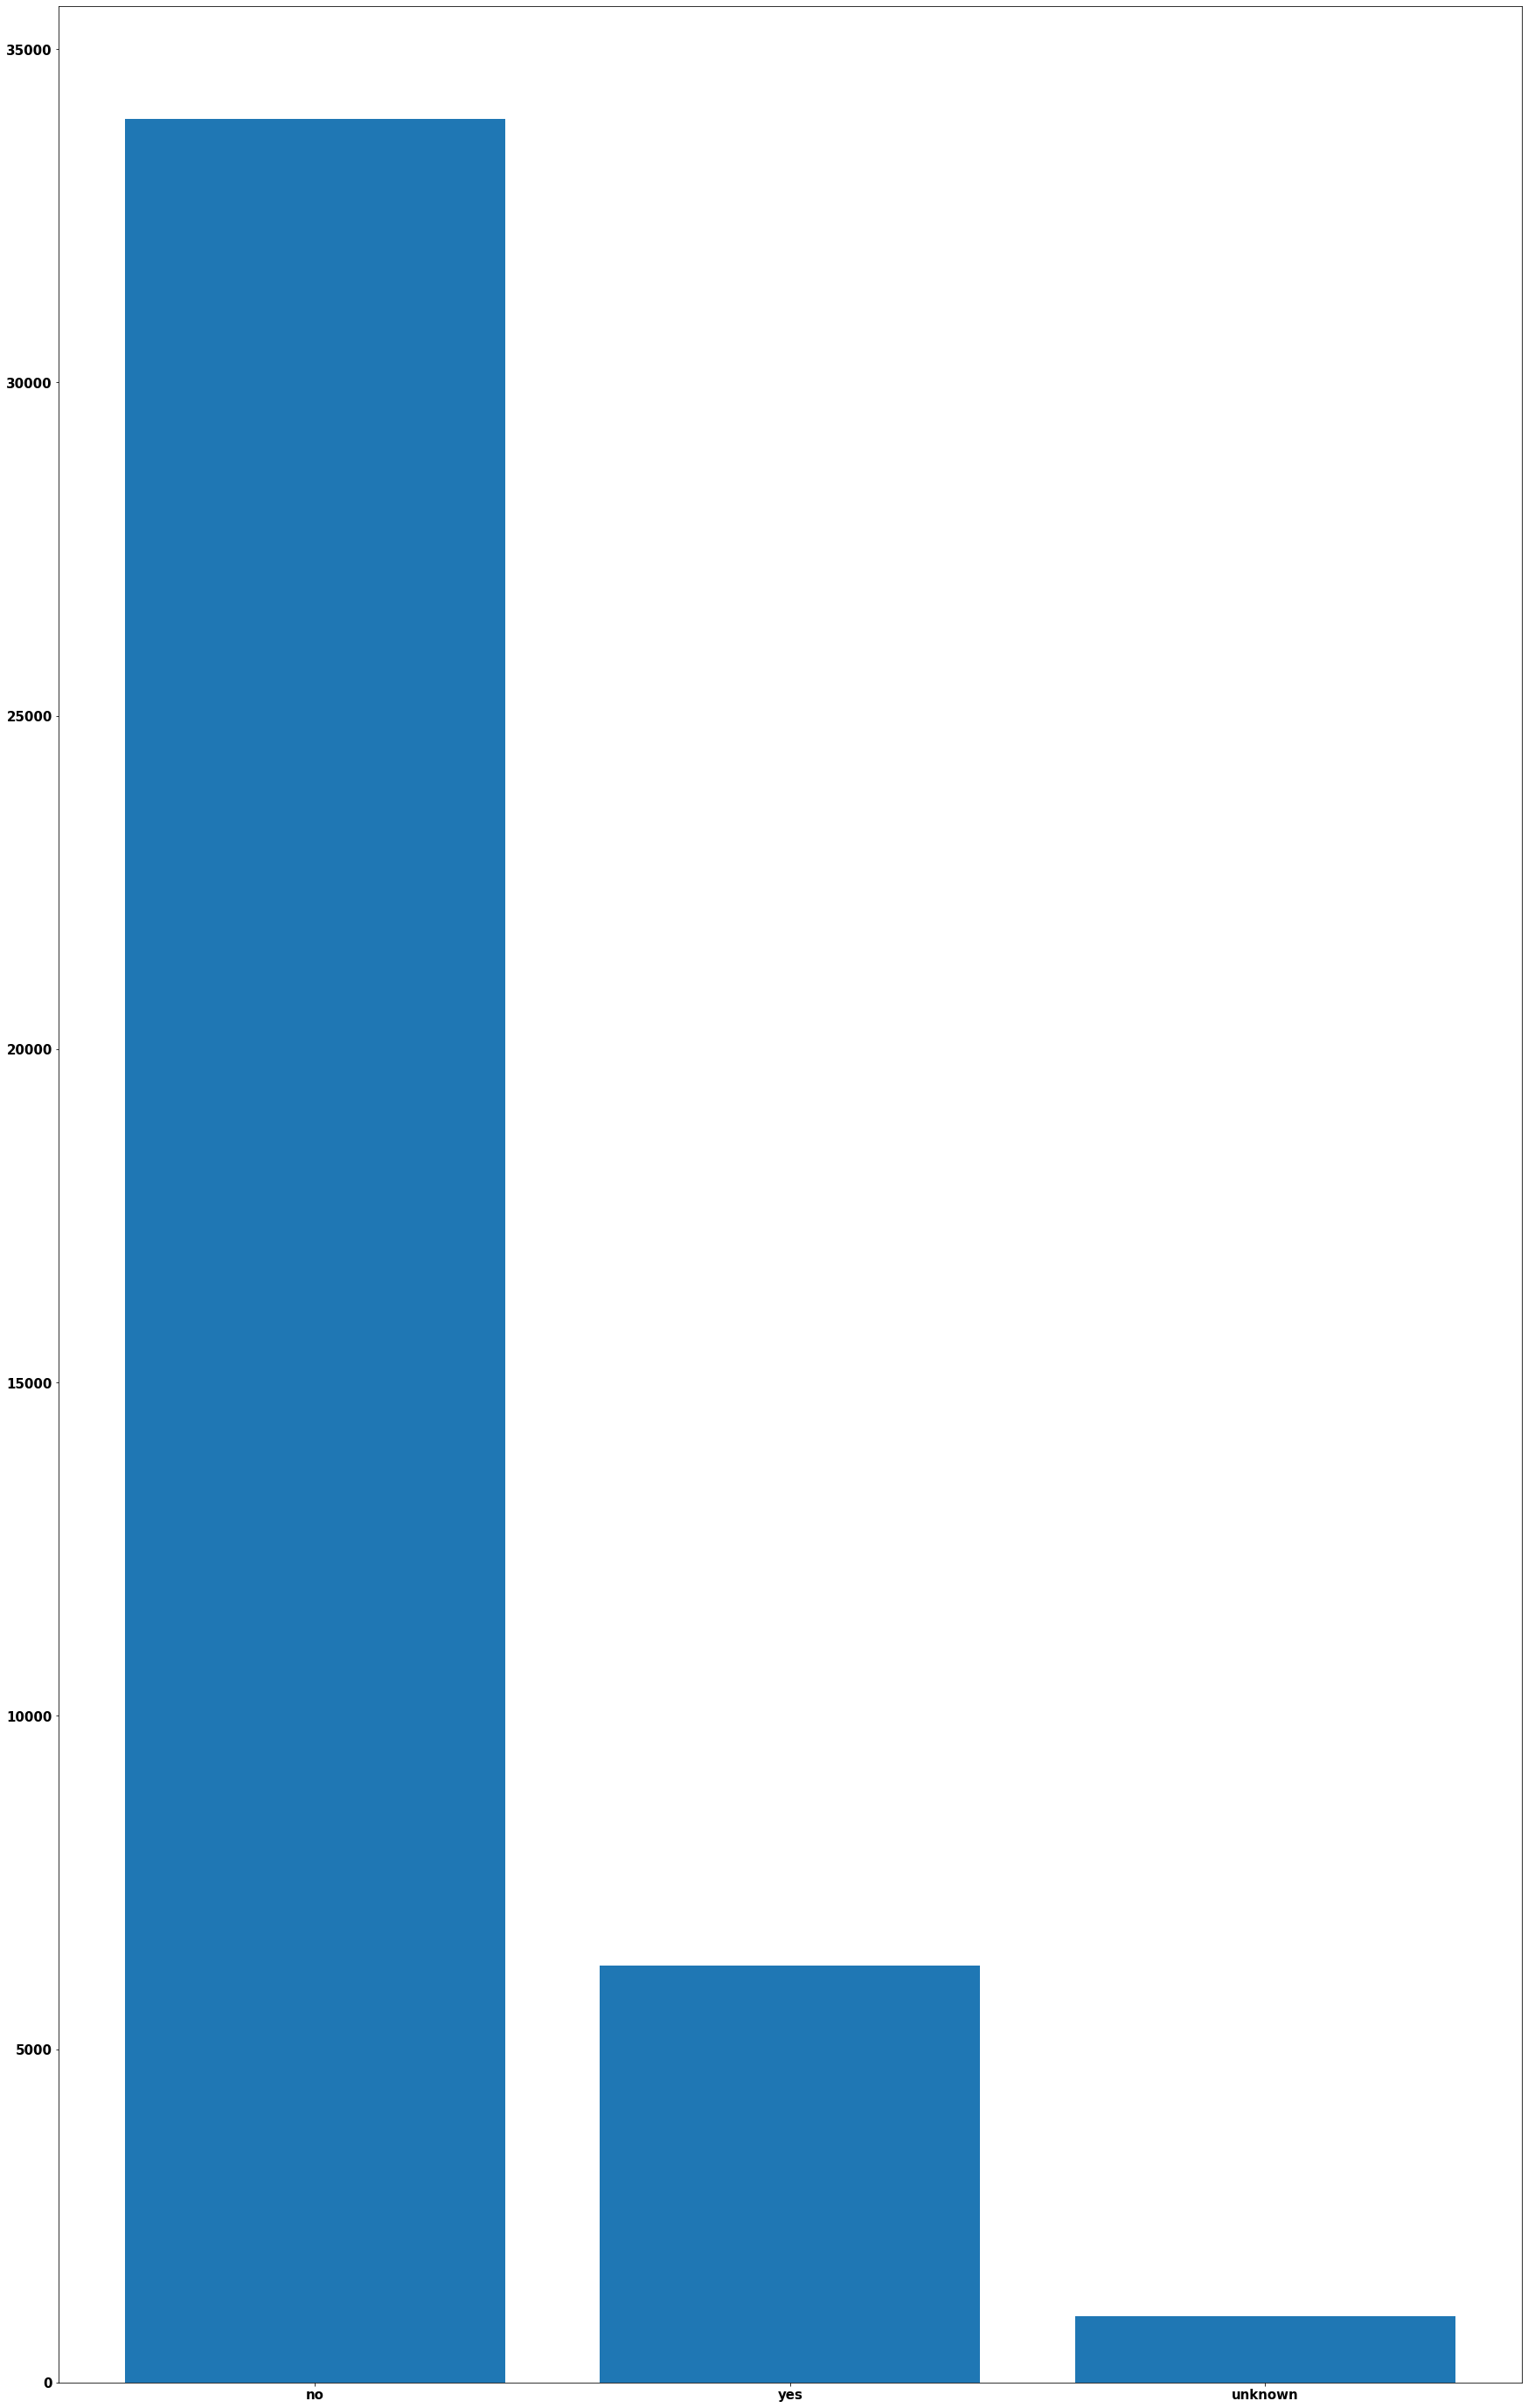

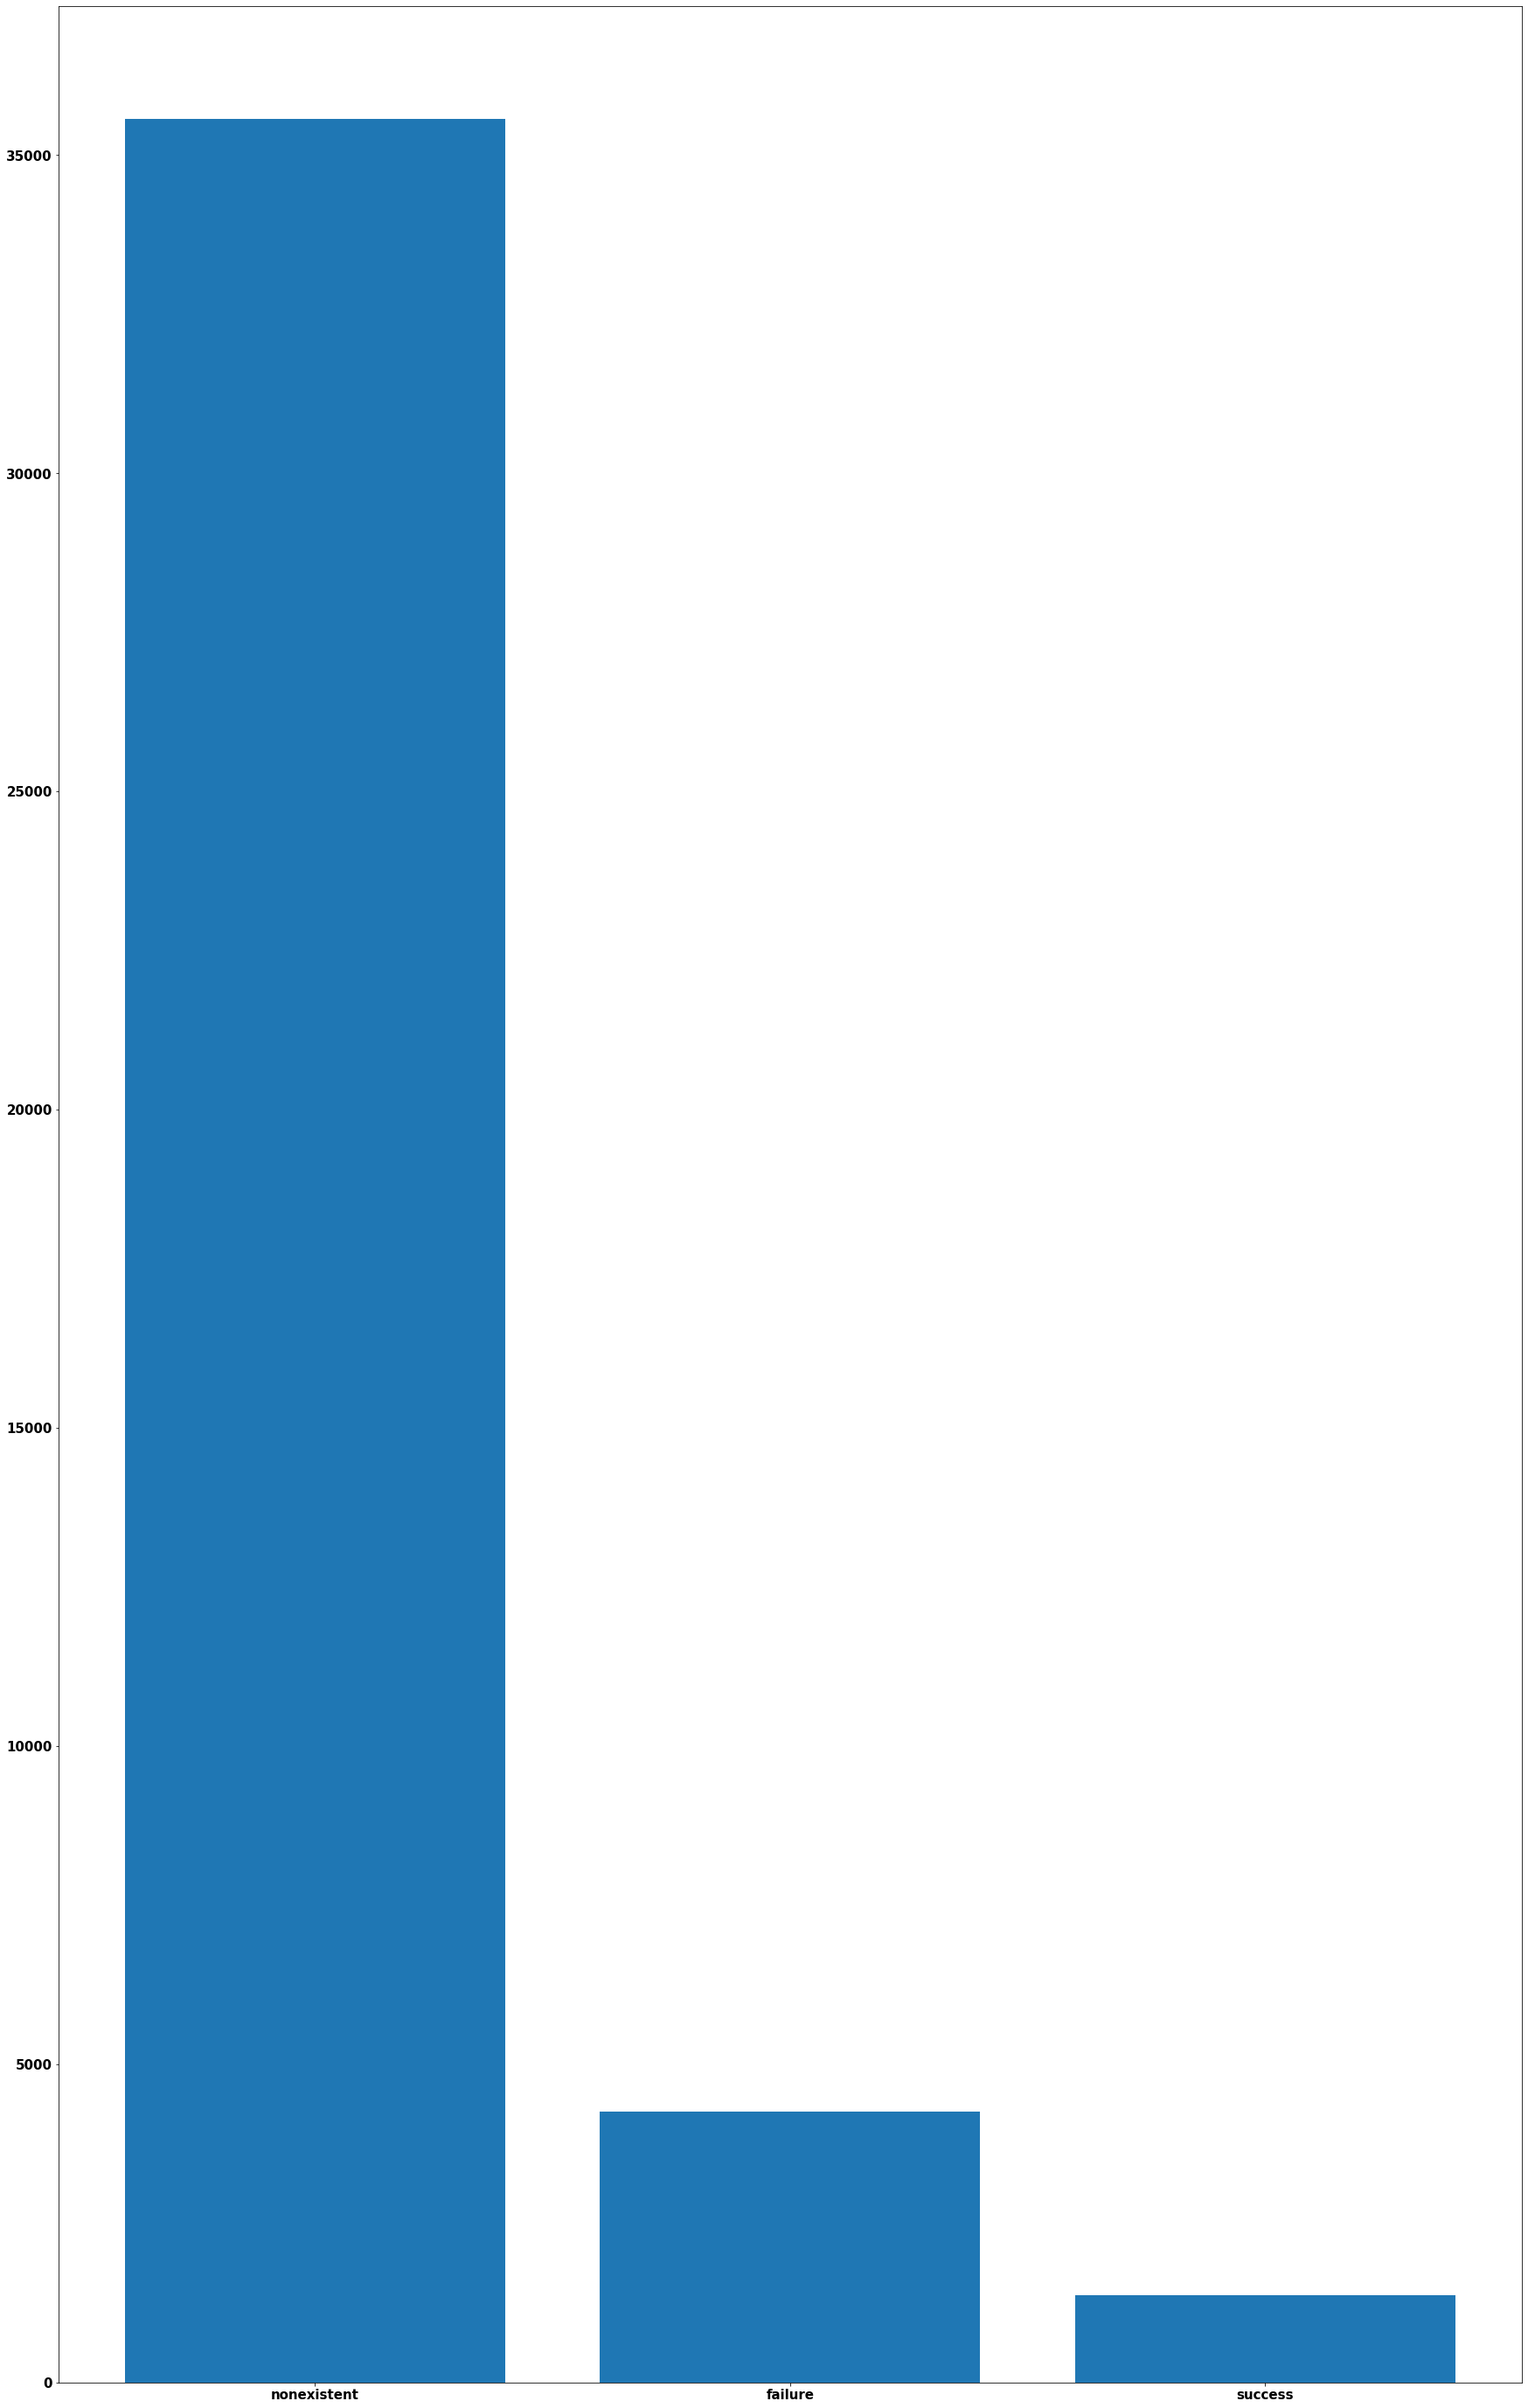

In [82]:
# fig, axs = plt.subplots(4, 2, figsize=(50, 40))
# fig.tight_layout()
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

plt.rc('font', **font)
i = 0
for col in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome']:
    # ax = axs[int(np.floor(i/2)), i%2]
    plt.figure(figsize=(30, 50))
    plt.bar(data.loc[:, col].value_counts().index, data.loc[:, col].value_counts().values)
    # ax.set_title(col)
    i += 1
    plt.show()
    # if i == 7:
        # plt.axis('off')

# plt.savefig('cat_var.png', dpi=600)
# plt.show()

# Data cleaning

# According to Week 8 there is outliers in duration, campaign.

####  1-Outlier detection and removal using 3 standard deviation


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


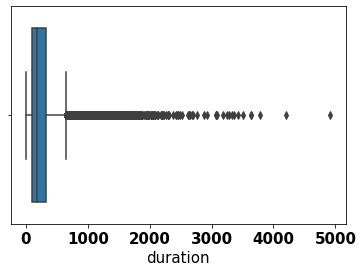

In [83]:
sns.boxplot('duration' , hue = 'y' , data =data)

In [84]:
upper_limit = data.duration.mean() + 3*data.duration.std()
upper_limit

1036.1227567065391

In [85]:
lower_limit = data.duration.mean() -3*data.duration.std()
lower_limit

-519.5527363122494

#### Here are the outliers that are beyond 3 std dev from mean



In [86]:
data[(data.duration>upper_limit) | (data.duration<lower_limit)]


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
37,52,technician,married,basic.9y,no,yes,no,telephone,may,mon,1666,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
75,41,blue-collar,divorced,basic.4y,unknown,yes,no,telephone,may,mon,1575,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
83,49,entrepreneur,married,university.degree,unknown,yes,no,telephone,may,mon,1042,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
88,49,technician,married,basic.9y,no,no,no,telephone,may,mon,1467,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
164,39,services,divorced,high.school,unknown,no,no,telephone,may,mon,2033,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40880,28,admin.,single,high.school,no,no,no,cellular,oct,wed,1246,2,999,0,nonexistent,-1.1,94.601,-49.5,0.959,4963.6,yes
40970,24,admin.,single,university.degree,no,yes,no,cellular,oct,fri,1176,3,3,2,success,-1.1,94.601,-49.5,0.993,4963.6,yes
41121,46,admin.,single,university.degree,no,yes,no,cellular,nov,tue,1166,3,999,1,failure,-1.1,94.767,-50.8,1.046,4963.6,no
41123,36,blue-collar,single,basic.6y,no,no,no,cellular,nov,tue,1556,4,999,0,nonexistent,-1.1,94.767,-50.8,1.046,4963.6,yes


#### Now remove these outliers and generate new dataframe

In [87]:
df_no_outlier_std_dev = data[(data.duration<upper_limit) & (data.duration>lower_limit)]
df_no_outlier_std_dev.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [88]:
df_no_outlier_std_dev.shape

(40327, 21)

In [89]:
data.shape

(41188, 21)

In [90]:
data = df_no_outlier_std_dev
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


#### 2- Outlier detection and removal using Z Score

Z score indicates how many standard deviation away a data point is.



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


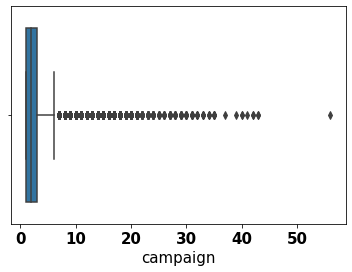

In [91]:
sns.boxplot('campaign' , hue = 'y' , data =data)

In [ ]:
data.campaign.mean()

In [93]:
data.campaign.std()

2.7782314231351304

For example in our case mean is 2.566568304113869 and standard deviation is 2.7782314231351304.
#### Calculate the Z Score



<img src="zscore.png" width=200 height=200>

In [94]:
data['zscore'] = ( data.campaign - data.campaign.mean() ) / data.campaign.std()
data.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,zscore
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,-0.563873
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,-0.563873
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,-0.563873
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,-0.563873
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,-0.563873


In [95]:
data['campaign'].head(1)

0    1
Name: campaign, dtype: int64

*Get data points that has z score higher than 3 or lower than -3. Another way of saying same thing is get data points that are more than 3 standard deviation away*

In [96]:
data[data['zscore']>3]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,zscore
2189,56,admin.,married,basic.9y,unknown,no,no,telephone,may,mon,10,11,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,3.035540
2234,47,management,married,university.degree,no,no,no,telephone,may,mon,24,12,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,3.395481
2554,31,admin.,married,high.school,unknown,yes,no,telephone,may,tue,101,13,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no,3.755422
2589,47,services,married,high.school,unknown,no,yes,telephone,may,tue,69,11,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no,3.035540
2590,47,blue-collar,married,professional.course,unknown,yes,no,telephone,may,tue,15,11,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no,3.035540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37587,28,unemployed,married,professional.course,no,no,no,telephone,aug,fri,140,11,999,0,nonexistent,-2.9,92.201,-31.4,0.869,5076.2,no,3.035540
37876,29,admin.,single,university.degree,no,yes,yes,cellular,aug,mon,121,12,999,0,nonexistent,-2.9,92.201,-31.4,0.821,5076.2,no,3.395481
37893,52,admin.,married,unknown,no,no,no,telephone,sep,tue,513,13,14,2,failure,-3.4,92.379,-29.8,0.819,5017.5,no,3.755422
40063,21,student,single,unknown,no,yes,yes,cellular,jul,thu,173,11,9,2,failure,-1.7,94.215,-40.3,0.810,4991.6,no,3.035540


In [97]:
data[data['zscore']<-3]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,zscore


Here is the list of all outliers

In [98]:
data[(data.zscore<-3) | (data.zscore>3)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,zscore
2189,56,admin.,married,basic.9y,unknown,no,no,telephone,may,mon,10,11,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,3.035540
2234,47,management,married,university.degree,no,no,no,telephone,may,mon,24,12,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,3.395481
2554,31,admin.,married,high.school,unknown,yes,no,telephone,may,tue,101,13,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no,3.755422
2589,47,services,married,high.school,unknown,no,yes,telephone,may,tue,69,11,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no,3.035540
2590,47,blue-collar,married,professional.course,unknown,yes,no,telephone,may,tue,15,11,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no,3.035540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37587,28,unemployed,married,professional.course,no,no,no,telephone,aug,fri,140,11,999,0,nonexistent,-2.9,92.201,-31.4,0.869,5076.2,no,3.035540
37876,29,admin.,single,university.degree,no,yes,yes,cellular,aug,mon,121,12,999,0,nonexistent,-2.9,92.201,-31.4,0.821,5076.2,no,3.395481
37893,52,admin.,married,unknown,no,no,no,telephone,sep,tue,513,13,14,2,failure,-3.4,92.379,-29.8,0.819,5017.5,no,3.755422
40063,21,student,single,unknown,no,yes,yes,cellular,jul,thu,173,11,9,2,failure,-1.7,94.215,-40.3,0.810,4991.6,no,3.035540


#### Remove the outliers and produce new dataframe


In [99]:
df_no_outliers_z = data[(data.zscore>-3) & (data.zscore<3)]
df_no_outliers_z.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,zscore
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,-0.563873
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,-0.563873
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,-0.563873
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,-0.563873
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,-0.563873


In [100]:
df_no_outliers_z.shape

(39473, 22)

In [101]:
data.shape


(40327, 22)

In [102]:
data = df_no_outliers_z
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,zscore
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,-0.563873
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,-0.563873
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,-0.563873
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,-0.563873
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,-0.563873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,-0.563873
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,-0.563873
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,-0.203931
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,-0.563873


Number Of Rows Befor Remove Outliers **41188**  and After Removing **39473**

<hr>

In [103]:
from sklearn.impute import KNNImputer

## Handle NA

### Marital and job

In [104]:
c_data = data.copy()
c_data.loc[:,'job'].loc[c_data.loc[:,'job']=='unknown'] = c_data.loc[:, 'job'].mode()
c_data.loc[:,'marital'].loc[c_data.loc[:,'marital']=='unknown'] = c_data.loc[:, 'marital'].mode()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


### Default, housing, loan and poutcome

In [105]:
print(c_data.loc[:,'default'].loc[c_data.loc[:,'y']=='yes'].value_counts())
c_data.loc[:,'default'].loc[c_data.loc[:,'y']=='no'].value_counts()

no         3772
unknown     333
Name: default, dtype: int64


no         27503
unknown     7862
yes            3
Name: default, dtype: int64

default is going to be ignored taking into account the distribution of the variables

In [106]:
print(c_data.loc[:,'housing'].loc[c_data.loc[:,'y']=='yes'].value_counts()/np.sum(c_data.loc[:,'housing'].loc[c_data.loc[:,'y']=='yes'].value_counts()))
c_data.loc[:,'housing'].loc[c_data.loc[:,'y']=='no'].value_counts()/np.sum(c_data.loc[:,'housing'].loc[c_data.loc[:,'y']=='no'].value_counts())

yes        0.544458
no         0.431912
unknown    0.023630
Name: housing, dtype: float64


yes        0.522704
no         0.453206
unknown    0.024090
Name: housing, dtype: float64

In [107]:
print(c_data.loc[:,'loan'].loc[c_data.loc[:,'y']=='yes'].value_counts()/np.sum(c_data.loc[:,'loan'].loc[c_data.loc[:,'y']=='yes'].value_counts()))
c_data.loc[:,'loan'].loc[c_data.loc[:,'y']=='no'].value_counts()/np.sum(c_data.loc[:,'loan'].loc[c_data.loc[:,'y']=='no'].value_counts())

no         0.831669
yes        0.144702
unknown    0.023630
Name: loan, dtype: float64


no         0.823767
yes        0.152143
unknown    0.024090
Name: loan, dtype: float64

housing and loan will be discarded due to the lack of variability between y classes.

In [108]:
print(c_data.loc[:,'poutcome'].loc[c_data.loc[:,'y']=='yes'].value_counts()/np.sum(c_data.loc[:,'poutcome'].loc[c_data.loc[:,'y']=='yes'].value_counts()))
c_data.loc[:,'poutcome'].loc[c_data.loc[:,'y']=='no'].value_counts()/np.sum(c_data.loc[:,'poutcome'].loc[c_data.loc[:,'y']=='no'].value_counts())

nonexistent    0.648965
success        0.213155
failure        0.137881
Name: poutcome, dtype: float64


nonexistent    0.884528
failure        0.102154
success        0.013317
Name: poutcome, dtype: float64

The meaning of the variable nonexistent can be considered by itself as no NA. Moreover, the percentage of nonexitent is considerably larger than the rest but considering the change between values, I will try to consider it like another value and see the impact of the model before deciding to delete the variable.

In [109]:
c_data.drop(['default', 'housing', 'loan'], axis=1, inplace=True)

### pdays

In [110]:
c_data.pdays.value_counts().sort_index()

0         15
1         26
2         60
3        434
4        116
5         44
6        402
7         60
8         17
9         62
10        51
11        27
12        56
13        35
14        19
15        24
16        11
17         8
18         7
19         2
20         1
21         2
22         3
25         1
26         1
27         1
999    37988
Name: pdays, dtype: int64

Considering the values and the frequency, I will change this column to if the client has been contacted or not.

In [111]:
c_data.loc[c_data.loc[:, 'pdays']!=999, 'pdays'] = 1
c_data.loc[c_data.loc[:, 'pdays']==999, 'pdays'] = 0

### education

In [112]:
print(c_data.loc[:,'education'].loc[c_data.loc[:,'y']=='yes'].value_counts()/np.sum(c_data.loc[:,'education'].loc[c_data.loc[:,'y']=='yes'].value_counts()))
c_data.loc[:,'education'].loc[c_data.loc[:,'y']=='no'].value_counts()/np.sum(c_data.loc[:,'education'].loc[c_data.loc[:,'y']=='no'].value_counts())

university.degree      0.369306
high.school            0.222168
professional.course    0.129842
basic.9y               0.095006
basic.4y               0.092083
unknown                0.055055
basic.6y               0.035566
illiterate             0.000974
Name: education, dtype: float64


university.degree      0.287011
high.school            0.231735
basic.9y               0.152935
professional.course    0.127432
basic.4y               0.102352
basic.6y               0.057877
unknown                0.040291
illiterate             0.000368
Name: education, dtype: float64

Categorical variables: dummy variables

Numeric variables: MinMax Scaler

In [113]:
num_col = c_data.describe().columns

In [114]:
scarler_list = []
for col in num_col:
    scaler = MinMaxScaler()
    supp_data = scaler.fit_transform(c_data[[col]])
    scarler_list.append(scaler)
    supp_data = pd.DataFrame(supp_data, columns=[col])
    c_data.drop([col], axis=1, inplace=True)
    c_data = pd.concat([c_data, supp_data], axis=1)

In [115]:
c_data.education.value_counts()

university.degree      11667
high.school             9108
basic.9y                5799
professional.course     5040
basic.4y                3998
basic.6y                2193
unknown                 1651
illiterate                17
Name: education, dtype: int64

In [116]:
supp_educ = ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 
             'university.degree', 'professional.course', 'unknown']
educ_dict = {supp_educ[i]:i for i in range(len(supp_educ))}

In [117]:
c_data.replace({'education':educ_dict}, inplace=True)

In [118]:
for col in c_data.describe(include='object').columns:
    supp_data = pd.get_dummies(c_data.loc[:,col], prefix=col, drop_first=True)
    c_data = pd.concat([c_data, supp_data], axis=1)
    c_data.drop([col],axis=1, inplace=True)

In [119]:
c_data.loc[:, 'education'].replace(7, np.nan, inplace=True)

In [120]:
imputer = KNNImputer(n_neighbors=10)
c_data_array = imputer.fit_transform(c_data)
c_data2 = pd.DataFrame(c_data_array, columns=c_data.columns)
c_data2.education = np.around(c_data2.education)

In [121]:
# We don't want any value less than 0 or greater than 6
print((c_data2.loc[c_data2.loc[:, 'education'].isnull(), 'education'] < 0).sum())
(c_data2.loc[c_data2.loc[:, 'education'].isnull(), 'education'] > 6).sum()

0


0

In [122]:
c_data2.loc[:, 'education']

0        1.0
1        4.0
2        4.0
3        2.0
4        4.0
        ... 
41183    6.0
41184    6.0
41185    5.0
41186    6.0
41187    6.0
Name: education, Length: 41188, dtype: float64

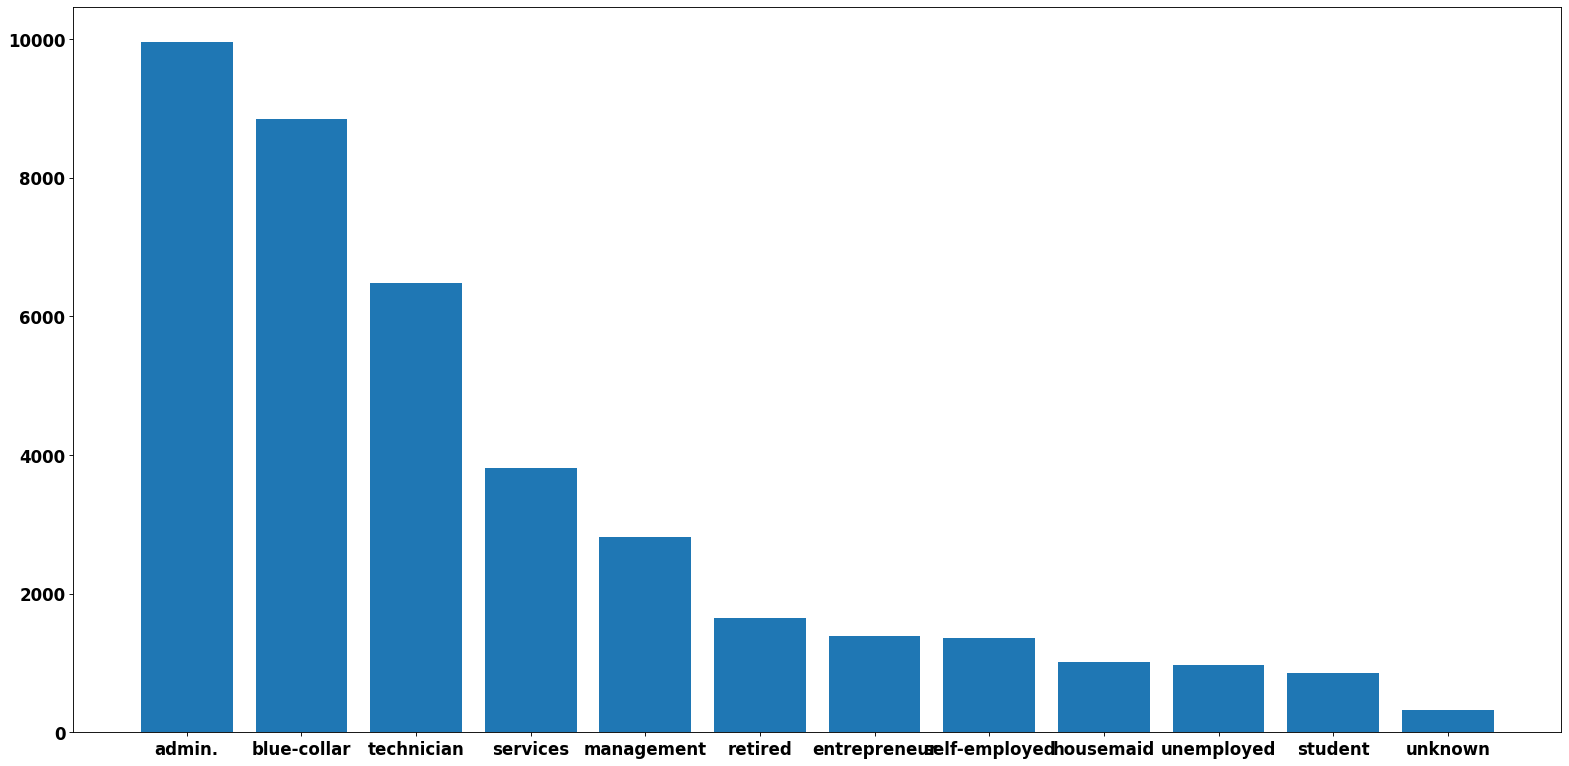

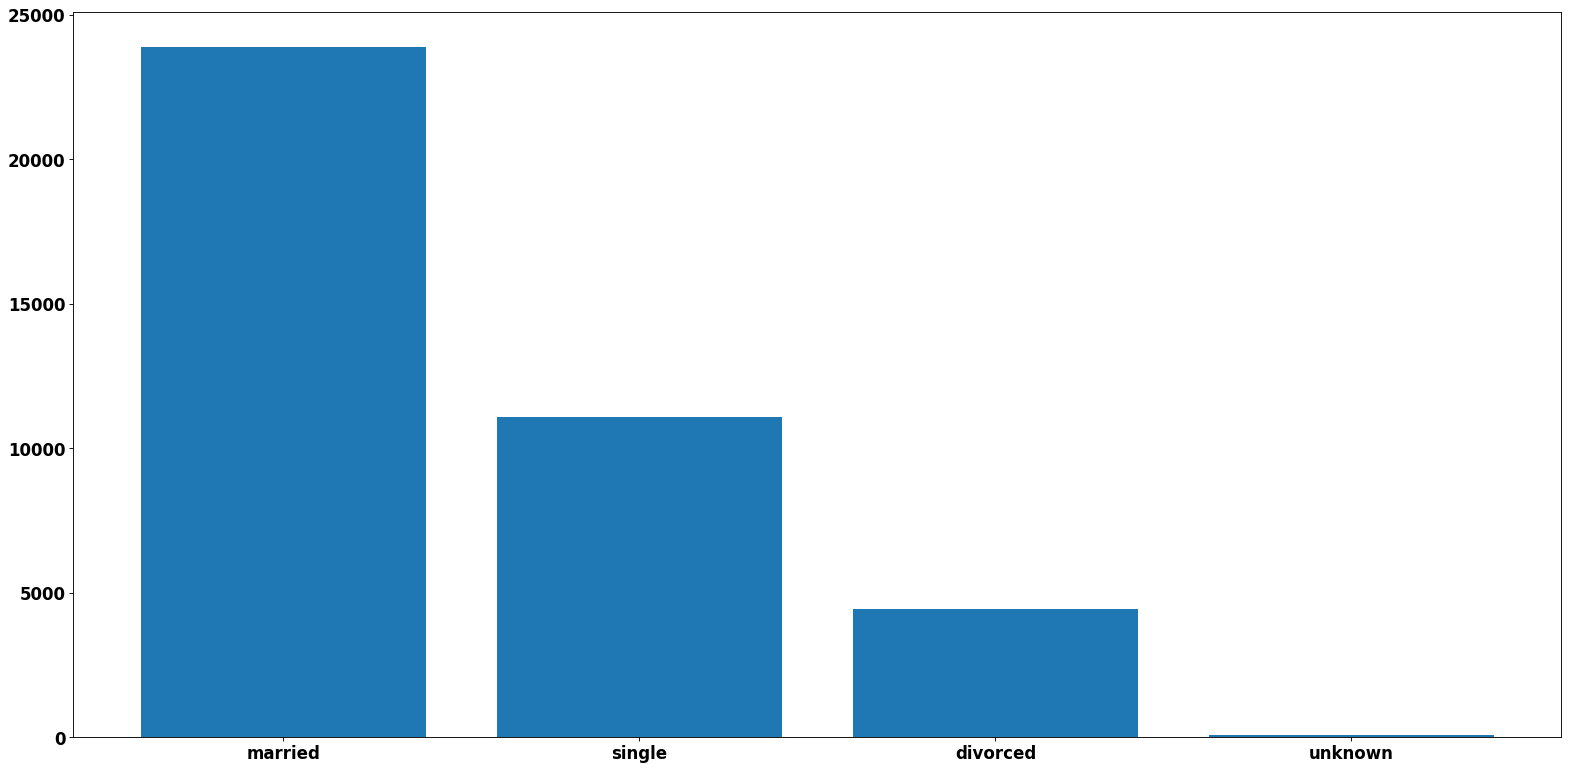

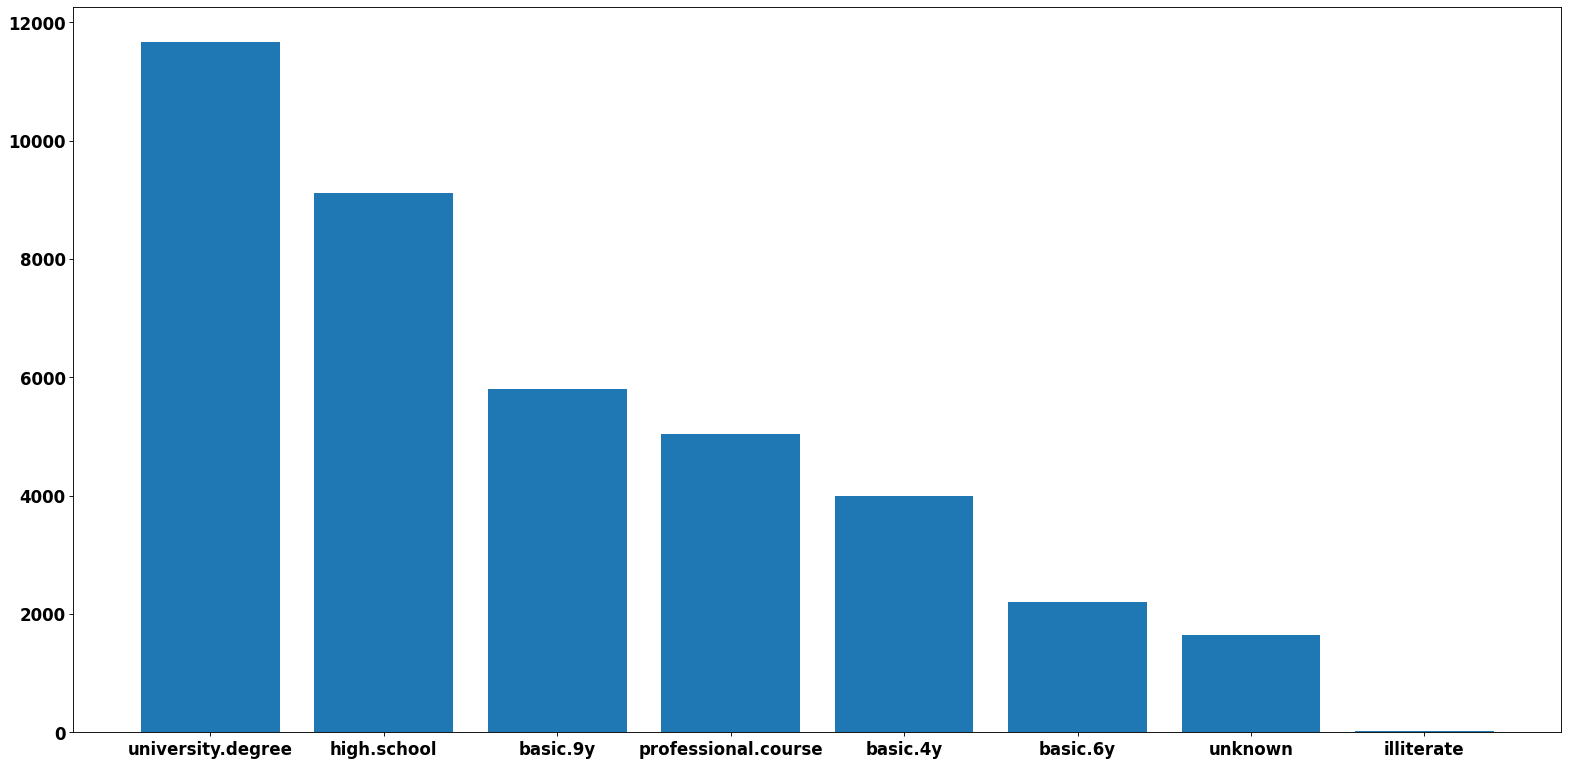

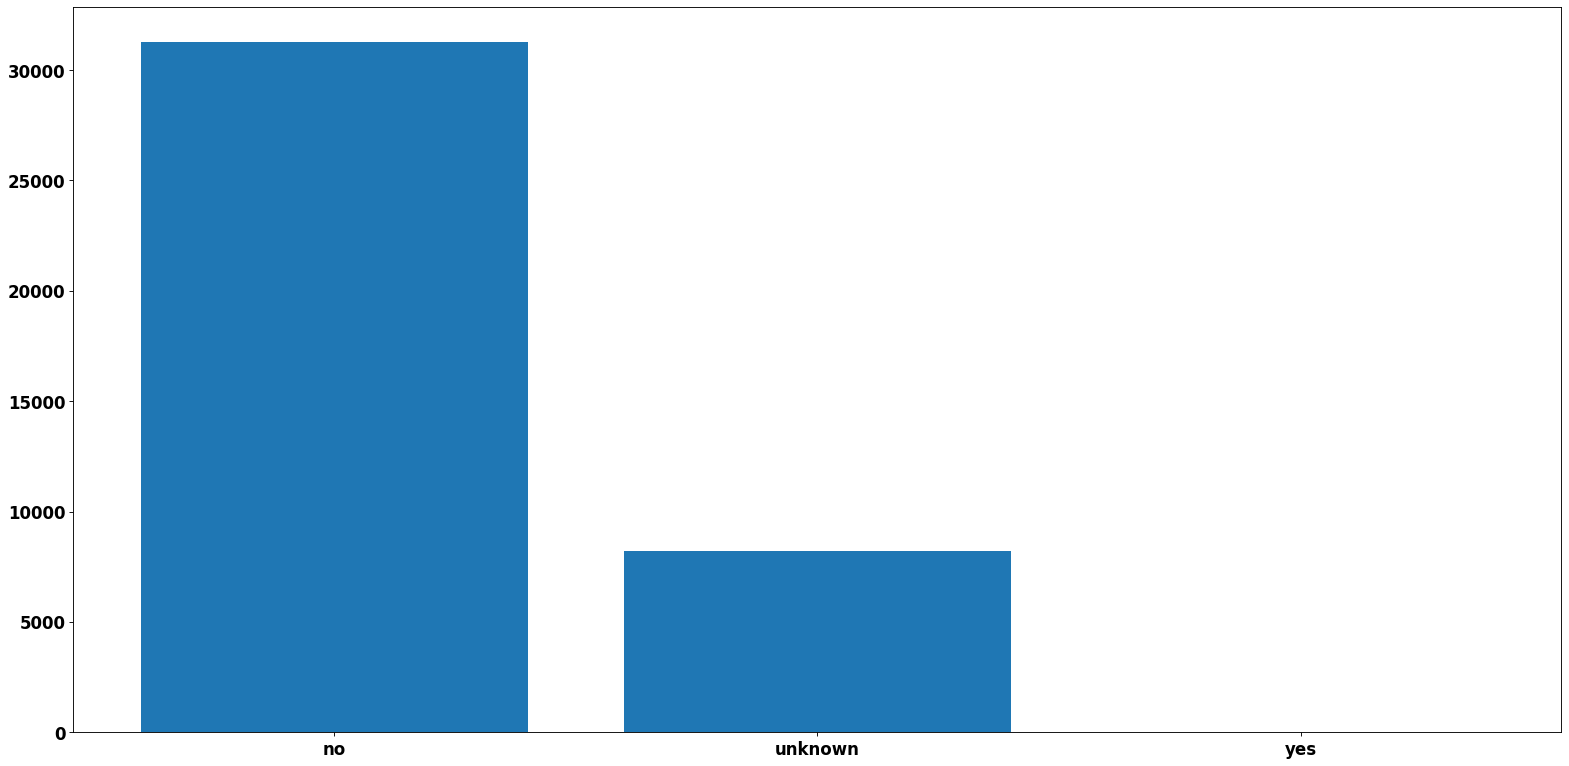

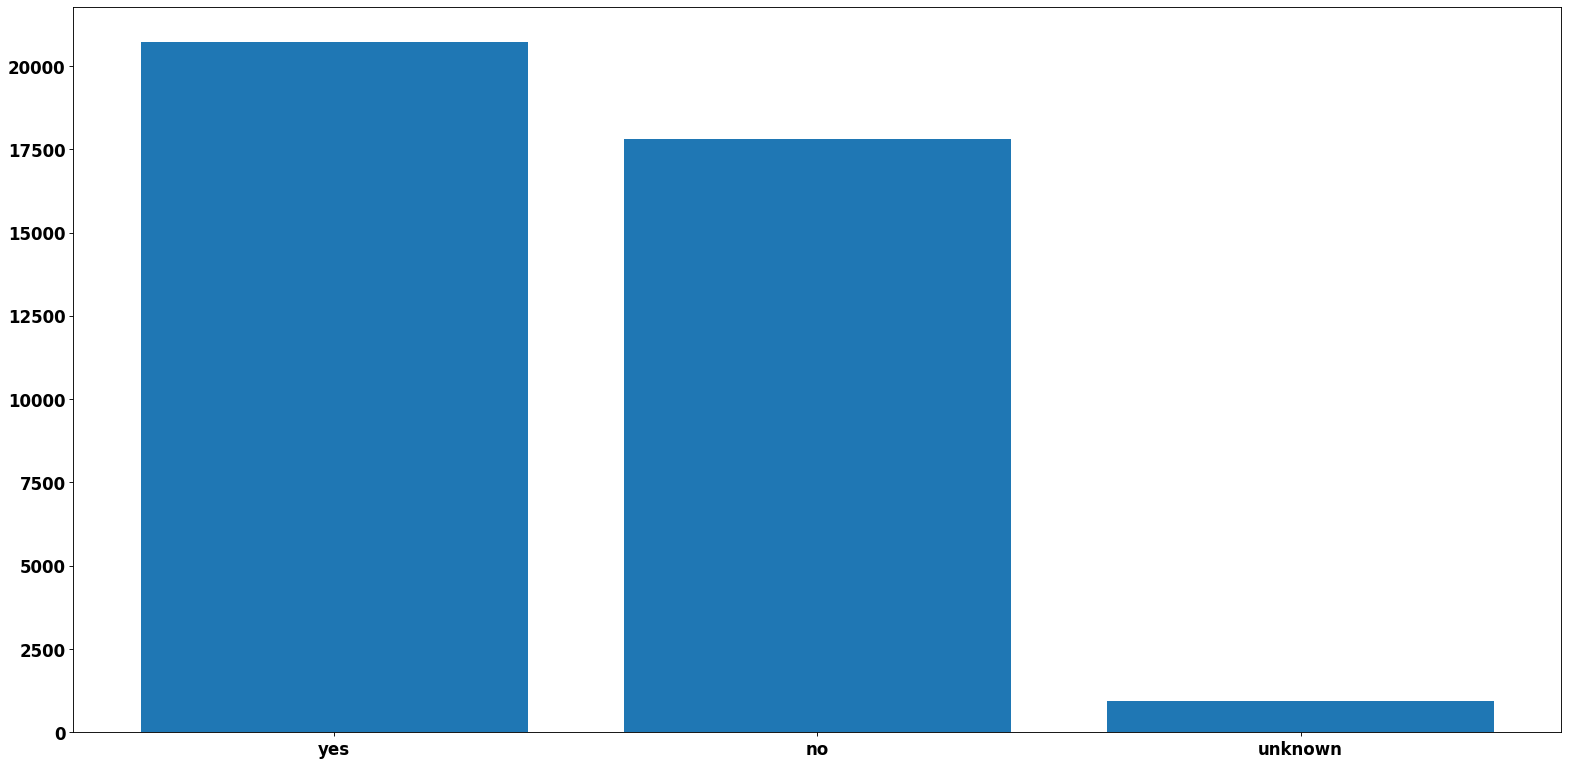

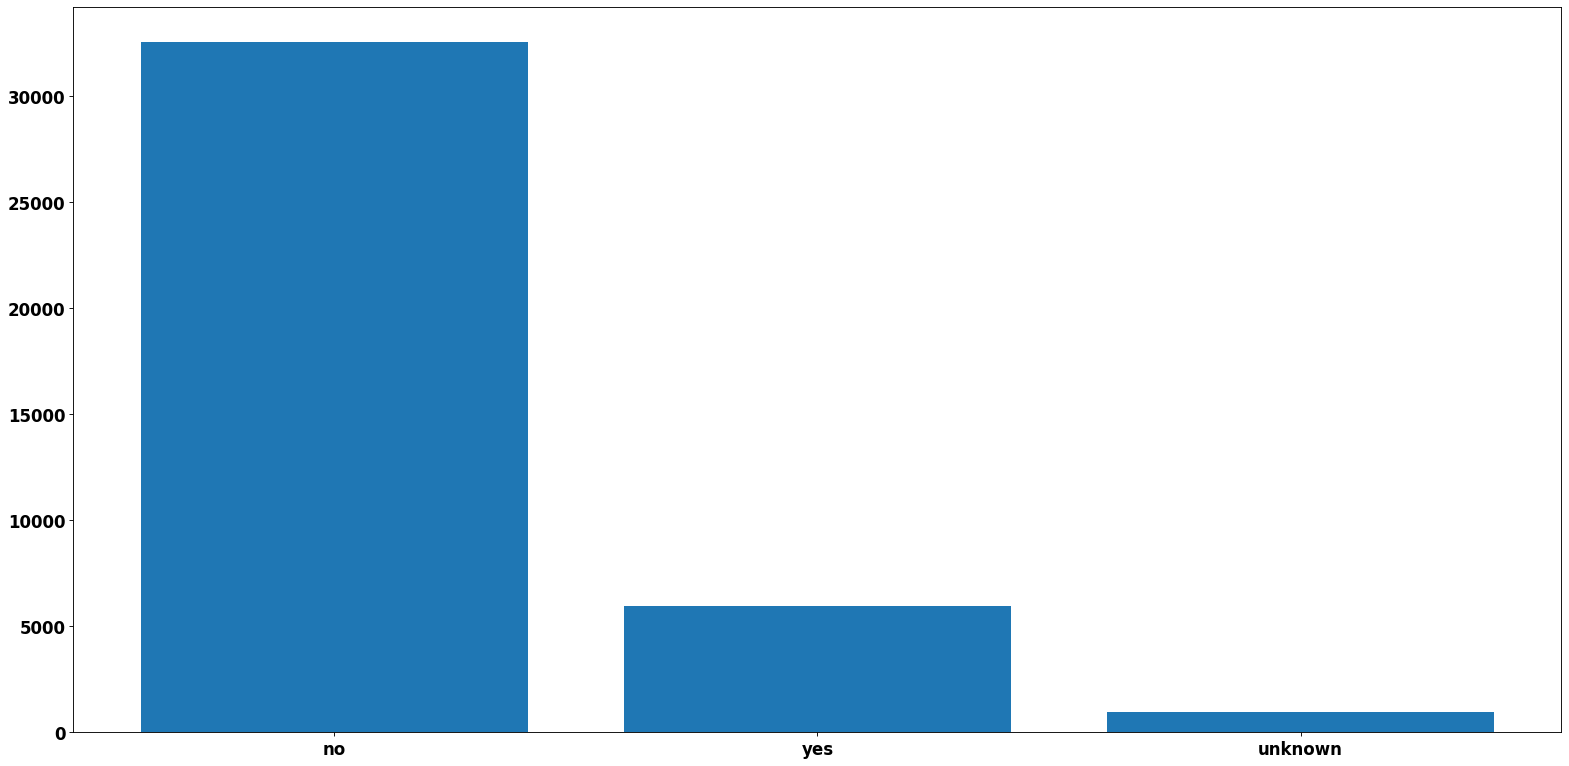

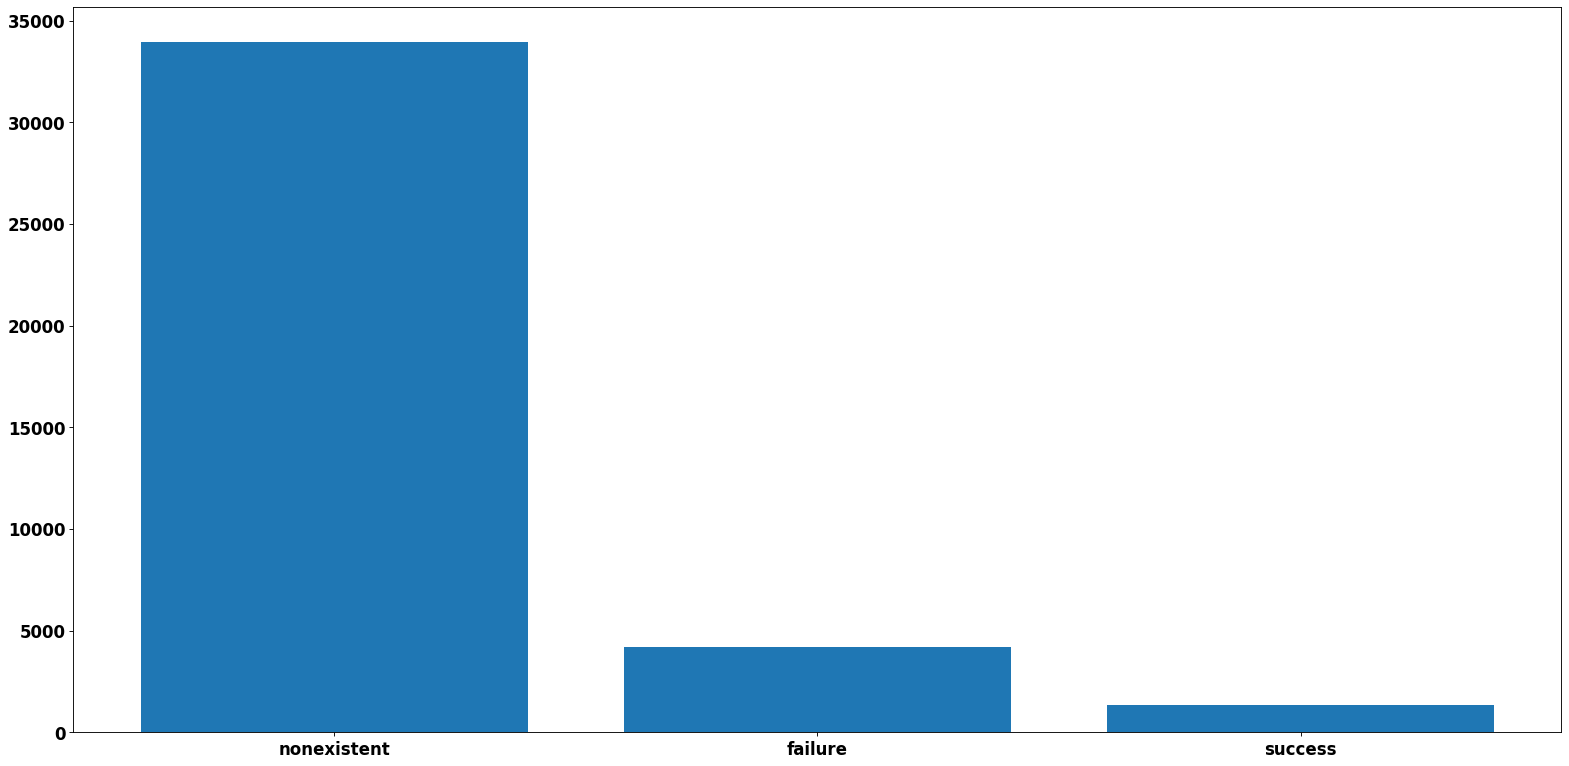

In [123]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

plt.rc('font', **font)
i = 0
for col in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome']:
    plt.figure(figsize=(24, 12), dpi=80)
    plt.bar(data.loc[:, col].value_counts().index, data.loc[:, col].value_counts().values)
    # plt.set_title(col)
    i += 1

In [124]:
c_data3 = c_data2.copy()
for i in range(len(num_col)):
    col = num_col[i]
    scaler = scarler_list[i]
    supp_data = scaler.inverse_transform(c_data3[[col]])
    supp_data = pd.DataFrame(supp_data, columns=[col])
    c_data3.drop([col], axis=1, inplace=True)
    c_data3 = pd.concat([c_data3, supp_data], axis=1)

In [125]:
scaler = MinMaxScaler()
c_data2.education = scaler.fit_transform(c_data2.education.values.reshape(-1, 1))

In [127]:
c_data3.to_csv('/content/drive/MyDrive/Colab Notebooks/cleaned_data.csv', index=False)
c_data2.to_csv("/content/drive/MyDrive/Colab Notebooks/cleaned_data_scaled.csv", index=False)

<hr>